We hereby declare that we have answered these exam questions ourselves without any outside help.

# Intro


## Outline / table of contents

## Imports, functions etc.

In [61]:
# imports
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import xarray as xr
import matplotlib.pyplot as plt

from scipy.stats import poisson
import seaborn as sns
from scipy.special import logit, expit
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
#style
az.style.use("arviz-whitegrid")

In [3]:
#seed
RANDOM_SEED = 8927
RNG = np.random.default_rng(RANDOM_SEED)

## Helper Functions

In [4]:
def standardize_column(column):
    '''
    Transforms column by its z-score.
    '''
    standardized_column = (column - column.mean()) / column.std()
    
    return standardized_column

def transform_exp(x):
    '''
    Transform a value to its exponential value. 
    '''
    return np.exp(x)

## EDA

In [12]:
## load data
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   project       1127 non-null   object
 1   language      1127 non-null   object
 2   commits       1127 non-null   int64 
 3   insertions    1127 non-null   int64 
 4   age           1127 non-null   int64 
 5   bugs          1127 non-null   int64 
 6   project_type  1127 non-null   object
 7   devs          1127 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 70.6+ KB


#### Catagorical Feature exploration


In [5]:
df_cat = df.select_dtypes(include = ['O'])
for column in df_cat.columns:
  print('===========================')
  print(f'Column name: {column}')
  print('===========================')
  print(f'# of unique values: {len(df_cat[column].value_counts())}')
  print(f'# of average counts: {df_cat[column].value_counts().mean()}')
  print()

NameError: name 'df' is not defined

In [13]:
# standardize columns
df['age_std'] = standardize_column(df['age'])
df['commits_std'] = standardize_column(df['commits'])
df['bugs_std'] = standardize_column(df['bugs'])

## factorize categorical
df["language"], languages = pd.factorize(df["language"])
df["project_type"], project_types = pd.factorize(df["project_type"])


# Main Analysis

## H1

### Poisson Regression

 **H1** - Haskell code is less prone to contain bugs (B). In other words, the distribution on the number of bugs (B) for Haskell gives high probability to the lowest number of bugs among all programming languages (L). 

We model the number of bugs with a poisson regression, to get the expected count of bugs for some language with the following model, that includes language as predictors and an intercept:
 $$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha + \beta_{L} L_i\\
\alpha \sim \text{Not determined yet} \\ 
\beta_{L} \sim \text{Not determined yet} $$
Where :
$$L \in \mathcal{L}, where \ \mathcal{L} = \{Python,Java..,C \} \\ |\mathcal{L}|=17 $$


### Prior Predictive Checks

Now what is a good choice of priors for alpha?

* One thing we can we say for sure is that the number of counts cannot be negative but the question is how many bugs an average project might have? First of all, there need to be some software pushed to the project, which is denoted by the number of commits **C**. As soon as a project has one commit, there must also be some probability that there is some bug in that pushed code. Based on own work experience, the number commits depending on what type of project, can range from a few commits to a 100. Some projects in the dataset we believe are much bigger meaning they have many more commits. A naive liveable space for the expected number of bugs would be in the interval $\lambda_i \in [0, \infty)$. Given our own experience, say that our project has a 100 commits and we are terrible programmers, this project would have a 100 bugs, so this is still a very large upper bound for the number of bugs. A more reasonable expected number of bugs could be a $1000$. 

* This belief about $\lambda_i$ is aimed to be reflected in the choice of prior for $\alpha$ that is the average number of bugs for a project.
* Since the expected value of $\lambda$ has a logarithmic relationship  to $\alpha$, the choice of priors can lead to exploding number of bugs using a prior with high variance. Another common choice of prior distribution, the standard normal $N(0,1)$, could lead to negative samples, that are mapped to expected value of bugs around 0. This amount of bugs in a project might also seem to good to be true.

* We explore the logarthmic relationship between alpha and the number of bugs with the following candidate prior distributions for alpha:
    * $\alpha \sim Exp(1)$
    * $\alpha \sim N(0,1)$
    * $\alpha \sim log \ N(0,1)$

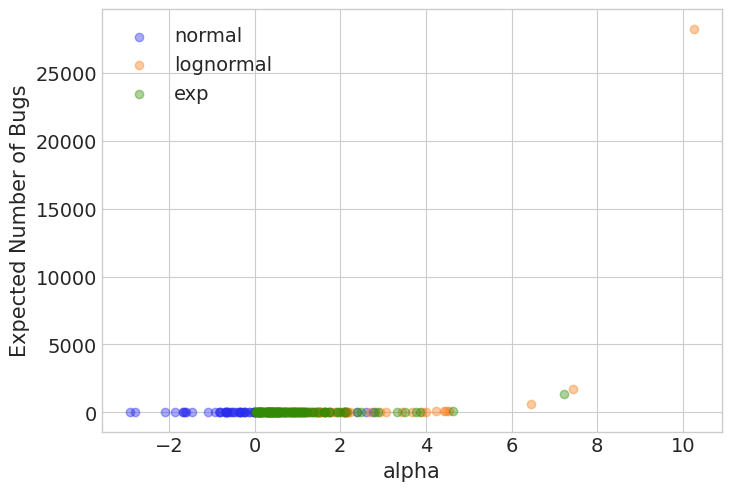

In [149]:
# First Initial Check
n_draws = np.random.normal(0, 1, 100)
ln_draws = np.random.lognormal(0,1,100)
exp_draws = np.random.exponential(1, 100)

plt.scatter(n_draws,np.exp(n_draws),label="normal", alpha=0.4)
plt.scatter(ln_draws,np.exp(ln_draws),label="lognormal", alpha=0.4)
plt.scatter(exp_draws,np.exp(exp_draws), label="exp",alpha=0.4)
plt.xlabel("alpha")
plt.ylabel("Expected Number of Bugs")
plt.legend()
plt.show()

From the plot above, it is already clear that the lognormal distribution yields exploding values for the number of bugs on average.

We can also see, that the normal distribution yields (as expected) a bunch of negative $\alpha$ values, that results in the average number of bugs to be very close to $0$. The exponential distributions heavy tailed characteristic shows from this initialisation a greater tendency than the standard normal $N (0,1)$ to yield exploding values. 

Next we run the prior predictive checks comparing the normal and exponential distribution, to find a good informative prior.

In [150]:
def prior_predictive_check_alpha_normal(alpha_mu_prior, alpha_sigma_prior):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

def prior_predictive_check_alpha_exp(alpha_lambda_prior):
    with pm.Model() as model:
        alpha = pm.Exponential("alpha", alpha_lambda_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


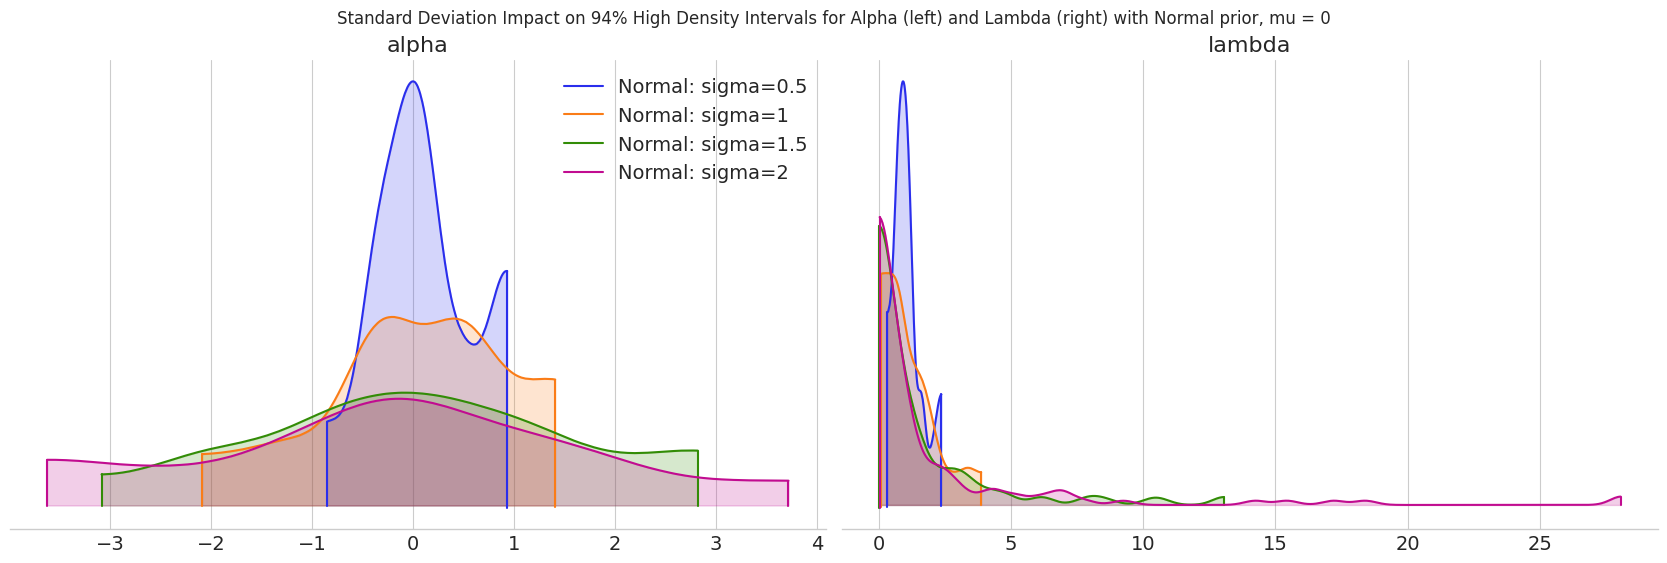

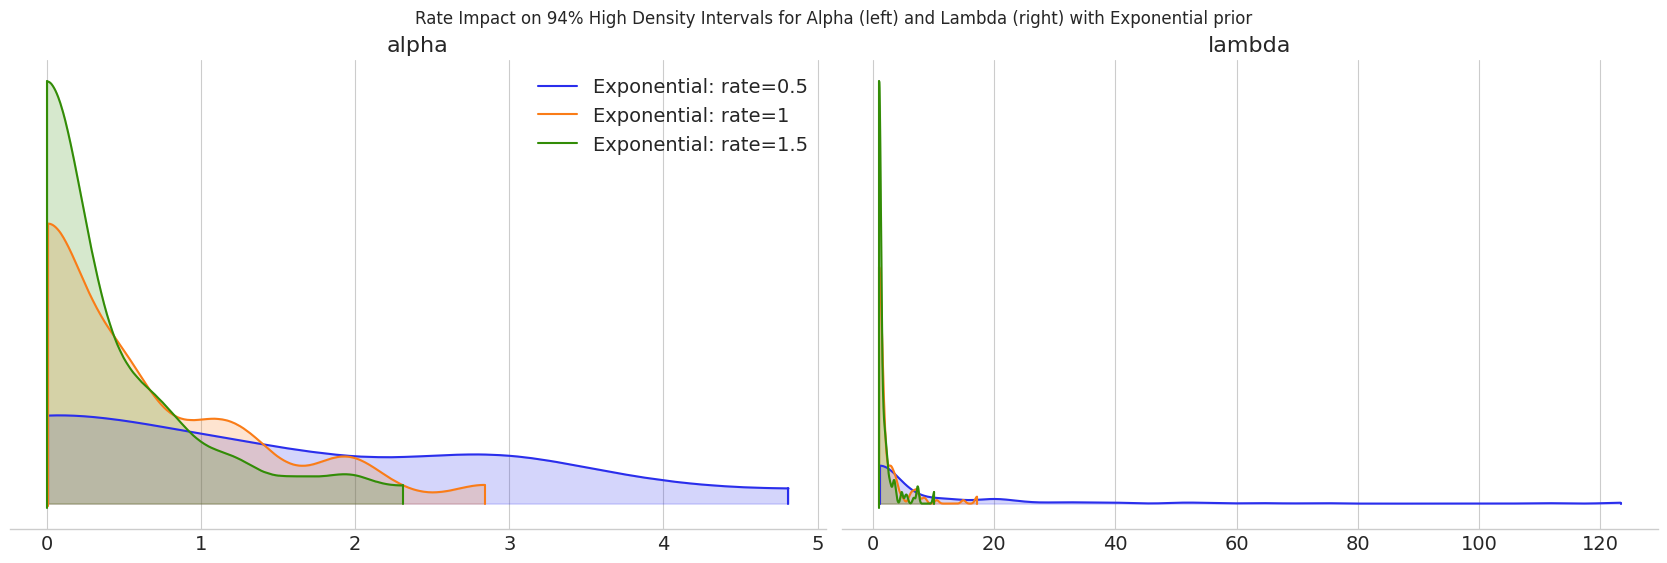

In [151]:
# Fixed Mu, varying sigmas
# Varying rate/lambda parameters
mu = 0
n_sigmas = [0.5, 1, 1.5, 2]
exp_lambdas = [0.5, 1, 1.5]


normal_traces, exponential_traces = [], []
normal_labels, exponential_labels = [], []


for sigma in n_sigmas:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    normal_traces.append(trace.prior)
    normal_labels.append(f"Normal: sigma={sigma}")

for exp in exp_lambdas:
    trace, model = prior_predictive_check_alpha_exp(exp)
    exponential_traces.append(trace.prior)
    exponential_labels.append(f"Exponential: rate={exp}")

axes = az.plot_density(
    normal_traces,
    data_labels=normal_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Standard Deviation Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, mu = 0")

axes = az.plot_density(
    exponential_traces,
    data_labels=exponential_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Rate Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Exponential prior")

plt.show()


* Based on the above KDE plots and prior predictive checks for Normal distribution with varying $\sigma$ and fixed $\mu=0$ and an exponential distribution with varying rates, it is clear that small changes in the rate (lambda) parameter of an exponential distribution is over sensitive to changes in terms of pushing expected number of bugs too close to $0$ or stretches it too far out, as it is seen with $\lambda = 0.5$. The normal distribution seem to be more a suitable choice of priors for the $\alpha$, although even with a $\sigma=2$ the simulated number of bugs gets a very heavy tail. Now to find the best prior, we fix the standard deviation of 1.5, and try to rid the models from most of the negative values by increasing the $\mu$ parameter.

Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


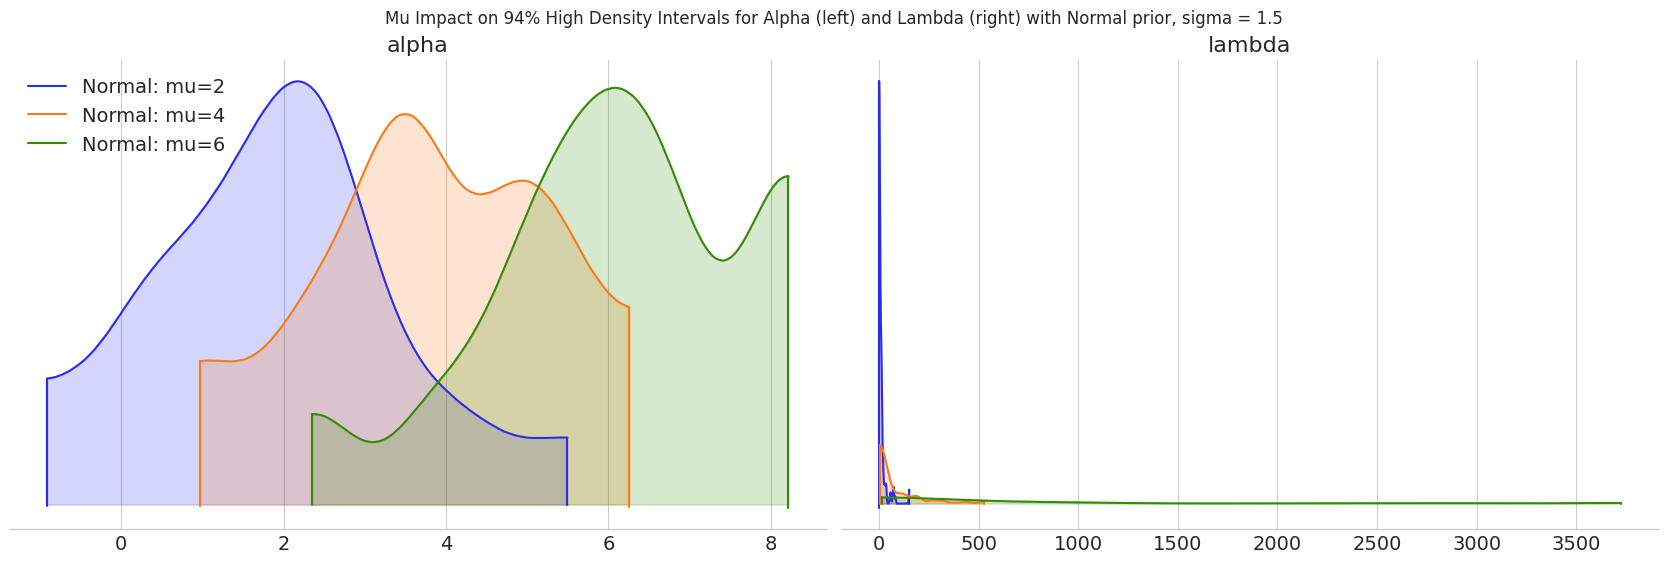

In [152]:
#Fixed Sigma, varying mu
sigma = 1.5
n_mus = [2,4,6]

traces, labels = [], []

for mu in n_mus:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    traces.append(trace.prior)
    labels.append(f"Normal: mu={mu}")

axes = az.plot_density(
    traces,
    data_labels=labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Mu Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, sigma = 1.5")
plt.show()

Based on the varying means in the prior predictive sampling for parameters $\alpha$ & $\lambda$ for the poisson distribution, the choice of prior distribution for modeling the average number bugs with $\alpha$ is $N(\mu=6, \sigma=1.5)$ since it shows from the plot above and highlighted below, that the probability mass lies within the range of $[0,\approx 5000)$. This is 10 times more than our own personal projects have had of commits, but these have also been tiny projects, and therefore not representative of what we expect from commercial applications commits and bugs distributions.

$$\alpha \sim N(6,1.5)$$

Sampling: [alpha]


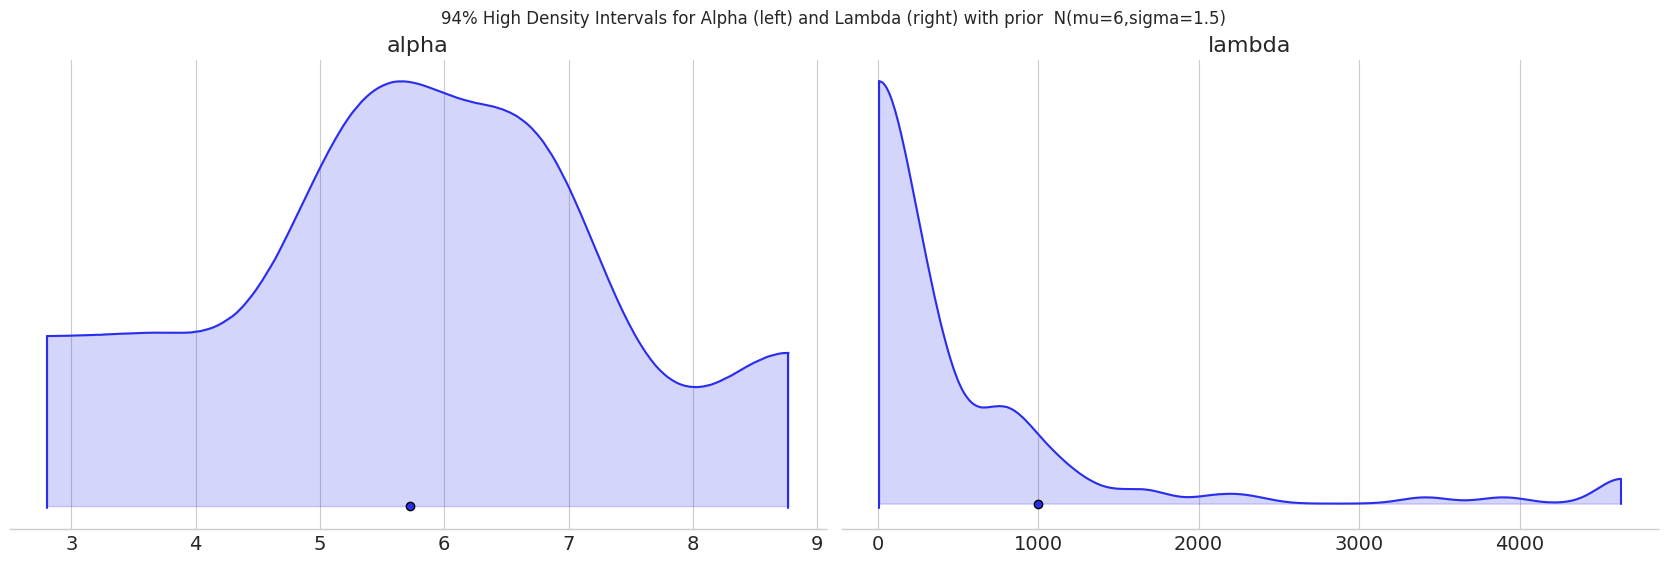

In [153]:
axes = az.plot_density(
    [prior_predictive_check_alpha_normal(6, 1.5)[0].prior],
    data_labels=["Prior Alpha selection = mu=4, sigma=1.5"],
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate="mean",
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("94% High Density Intervals for Alpha (left) and Lambda (right) with prior  N(mu=6,sigma=1.5)")
plt.show()

The best choice of prior for the beta coefficients is an uninformed standard normal distribution $\beta_L \sim N(0,1)$, this choice does not include any positive or negative trends simply based on the project's programming language, and this is desirable for our poisson regression:

$$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha + \beta_L L_i \\
\alpha \sim N(6,1.5) \\ 
\beta_L \sim N(0,1)$$

### Model Fitting

model : <hypothesis_modeltype_model>
trace:  <hypothesis_modeltype_trace>

In [124]:
## Poisson Modeling
with pm.Model() as h1_poisson_model:
      #Data
      language = pm.Data("language", df.language, mutable=True)
      
      # Priors
      alpha = pm.Normal("alpha", mu=6, sigma=1.5, shape=len(languages))

      #f(theta, x)
      lam= pm.Deterministic('lambda', pm.math.exp(alpha[language]))

      #likelihood
      B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
      h1_poisson_trace = pm.sample(2000, tune=2000,idata_kwargs={'log_likelihood': True}, random_seed=RANDOM_SEED, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 65 seconds.


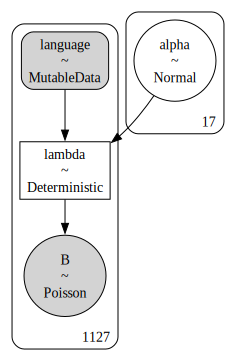

In [160]:
pm.model_to_graphviz(model=h1_poisson_model)

Below is the trace convergence for the parameters $\alpha$ and $\beta_L$.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

As seen in the table below, the Monte Carlo Standard Error mean `mcse_mean`, is $0$ for all parameters except for `beta_language[0]` of $0.01$. These MSCE's indicate effective sampling of the mode of the distributions in all 4 chains, whilst the equivalent entries in `mcse_sd` show the chains could sample from the mode without high variance. This is also shown by the $>800$ for the `ess_bulk` and `ess_tail`, that shows the number of samples that added new information about the posterior distribution.

In addition, all the `rhat` values are $1.0$ or $1.01$ which means the 4 chains converged. This is also reflected in the trace plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for the poisson regression
 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [162]:
az.summary(h1_poisson_trace, var_names=["alpha"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]   4.79  0.01    4.77     4.81        0.0      0.0  14934.38   
alpha[1]   5.26  0.01    5.25     5.27        0.0      0.0  12555.28   
alpha[2]   4.83  0.01    4.81     4.85        0.0      0.0  16205.90   
alpha[3]   6.16  0.01    6.15     6.17        0.0      0.0  15529.93   
alpha[4]   6.72  0.00    6.71     6.73        0.0      0.0  14872.18   
alpha[5]   6.90  0.00    6.89     6.91        0.0      0.0  14933.95   
alpha[6]   4.28  0.02    4.24     4.32        0.0      0.0  15678.01   
alpha[7]   7.71  0.00    7.70     7.71        0.0      0.0  14102.07   
alpha[8]   6.83  0.00    6.82     6.83        0.0      0.0  14080.57   
alpha[9]   5.26  0.01    5.24     5.29        0.0      0.0  14516.20   
alpha[10]  5.58  0.01    5.56     5.60        0.0      0.0  13580.46   
alpha[11]  3.71  0.02    3.67     3.75        0.0      0.0  15718.80   
alpha[12]  6.12  0.01    6.10     6.13        0.0      0.0  15983.78   
alpha[13]  4.78  0.01    4.76     4.81        0.0      0.0  13410.86   
alpha[14]  6.01  0.00    6.00     6.02        0.0      0.0  14094.59   
alpha[15]  4.75  0.02    4.73     4.78        0.0      0.0  14364.37   
alpha[16]  5.64  0.01    5.62     5.66        0.0      0.0  15384.01   

           ess_tail  r_hat  
alpha[0]    6038.35    1.0  
alpha[1]    4771.13    1.0  
alpha[2]    5125.56    1.0  
alpha[3]    5984.54    1.0  
alpha[4]    6567.39    1.0  
alpha[5]    5775.91    1.0  
alpha[6]    6125.23    1.0  
alpha[7]    5651.11    1.0  
alpha[8]    5671.82    1.0  
alpha[9]    5485.67    1.0  
alpha[10]   6056.37    1.0  
alpha[11]   6152.58    1.0  
alpha[12]   5864.25    1.0  
alpha[13]   6045.60    1.0  
alpha[14]   5441.46    1.0  
alpha[15]   5853.25    1.0  
alpha[16]   6269.35    1.0

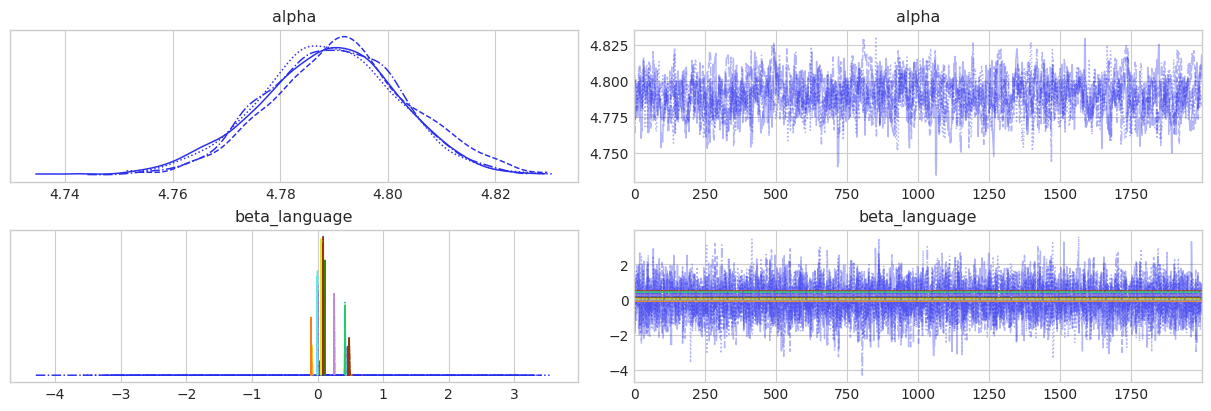

In [21]:
pm.plot_trace(h1_poisson_trace, var_names=['alpha', "beta_language"]);

Below is a forest plot and a numerical representation of the means and standard deviations (sd) from the posterior distributions of the **$\beta_L$** and $\alpha$. The $\alpha$ prior $\mu=6$ is now reduced to $\mu=4.7897$ with a high confidence shown by the $\sigma=0.0127$. This shows that the average number of bugs was overestimated by the prior, but also that the sampling was able to estimate the posterior with high accuracy. Similarly, all the $\beta_L$ except for the `beta_language[0]` has very small standard deviations. This also indicates the confidence of the estimated posterior distributions. The means of the $\beta_L$ distributions show different effects of some languages over the others, but all fall within the small range of $(-0.0982,0.4819)$. Especially the negative effects are notably very close to $0$, whereas the largest mean value for `beta_language[4]`=$0.4819$, which indicates a positive correlation between this particular language and the number of bugs. These differences are also seen below in forest plot.

In [73]:
#summary betas
summary_betas_poisson = pm.summary(h1_poisson_trace, var_names=['beta_language'],round_to=4)[['mean', 'sd']].reset_index(names="parameter")
summary_betas_poisson["language"] = languages.take(summary_betas_poisson.index)
#summary alphas
summary_alpha_poisson = pm.summary(h1_poisson_trace, var_names=['alpha'],round_to=4)[['mean', 'sd']].reset_index(names="parameter")
#combined summary
summary_poisson = pd.concat([summary_alpha_poisson, summary_betas_poisson])
print(summary_poisson)

            parameter    mean      sd      language
0               alpha  4.7897  0.0127           NaN
0    beta_language[0]  0.0014  0.9919       Clojure
1    beta_language[1]  0.4682  0.0138    Javascript
2    beta_language[2]  0.0193  0.0088   Objective-C
3    beta_language[3]  0.4568  0.0046          Java
4    beta_language[4]  0.4819  0.0034           Php
5    beta_language[5]  0.4222  0.0027            C#
6    beta_language[6] -0.0854  0.0044          Perl
7    beta_language[7]  0.4167  0.0019             C
8    beta_language[8]  0.2544  0.0016           C++
9    beta_language[9]  0.0527  0.0019        Erlang
10  beta_language[10]  0.0789  0.0016       Haskell
11  beta_language[11] -0.0982  0.0022    Typescript
12  beta_language[12]  0.1105  0.0012          Ruby
13  beta_language[13] -0.0006  0.0014  Coffeescript
14  beta_language[14]  0.0873  0.0010        Python
15  beta_language[15] -0.0025  0.0013            Go
16  beta_language[16]  0.0531  0.0010         Scala


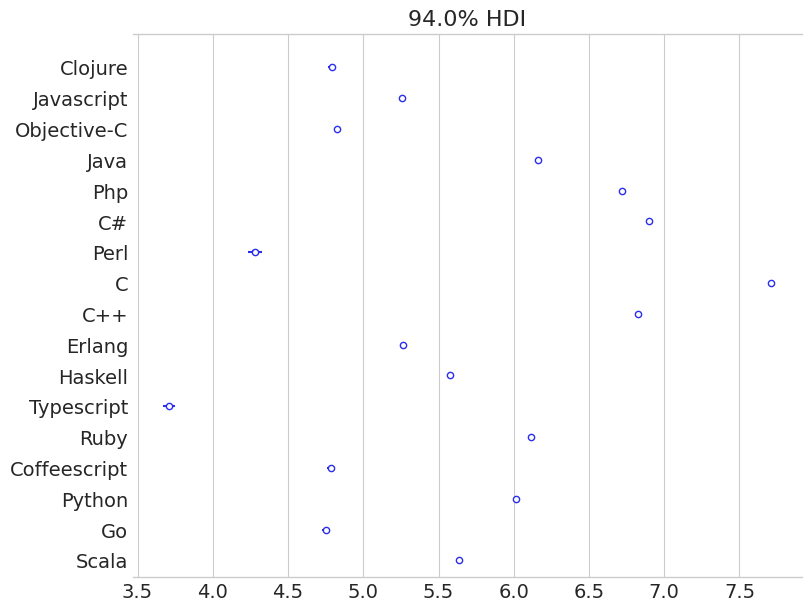

In [164]:
_,ax = plt.subplots(figsize=(8,6))
az.plot_forest(h1_poisson_trace, var_names=["alpha"], combined=True, figsize=(10, 5), ax=ax)
forest_languages = [int(i.get_text()[1:-1]) if len(i.get_text()) < 6 else 0 for i in ax.get_yticklabels()]
ax.set_yticklabels(languages.take(forest_languages)); 

### Posterior Predictive Check

In [165]:
pareto_k_h1 = az.loo(h1_poisson_trace, pointwise=True).pareto_k.values
print("Max PSIS value for beta_language: ", max(pareto_k_h1))

Max PSIS value for beta_language:  67.36852635307598


/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


*"Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations"*

This warning indicates that some projects are highly influential on the model, and that taking them at out at random, changes the posterior distribution.

In [166]:
n_points = len(df)
# x_seq = np.random.randint(0, 17,size=n_points)
x_seq = np.array(range(len(languages)))
# print(x_seq)
with h1_poisson_model:
    pm.set_data({"language": x_seq})
    post_pred_h1 = pm.sample_posterior_predictive(h1_poisson_trace, var_names=['lambda'])['posterior_predictive']['lambda']
    
post_pred_h1_mean = post_pred_h1.mean(["chain", "draw"])

Sampling: []


To investigate the highly influential datapoints, below is plotted the Poisson Regression Models 95% HDI as well as the individual observations for each datapoint. Each entry in the plot is sized by its pareto smooth importance value. It is clear from the plot, that some projects like `Linux` written in `C` has more bugs than twice the order of magnitudes of the other projects. This is also denoted by the red circle and its value of 1, that originally was (as seen above) $78.7456$. The other projects relative `PSIS` values have equally been normalized, and required a scaling in size of $3000$, to be used for the plot below. This indicates that some projects in combination with some languages have a great outlying number of bugs compared to the average estimation.

/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


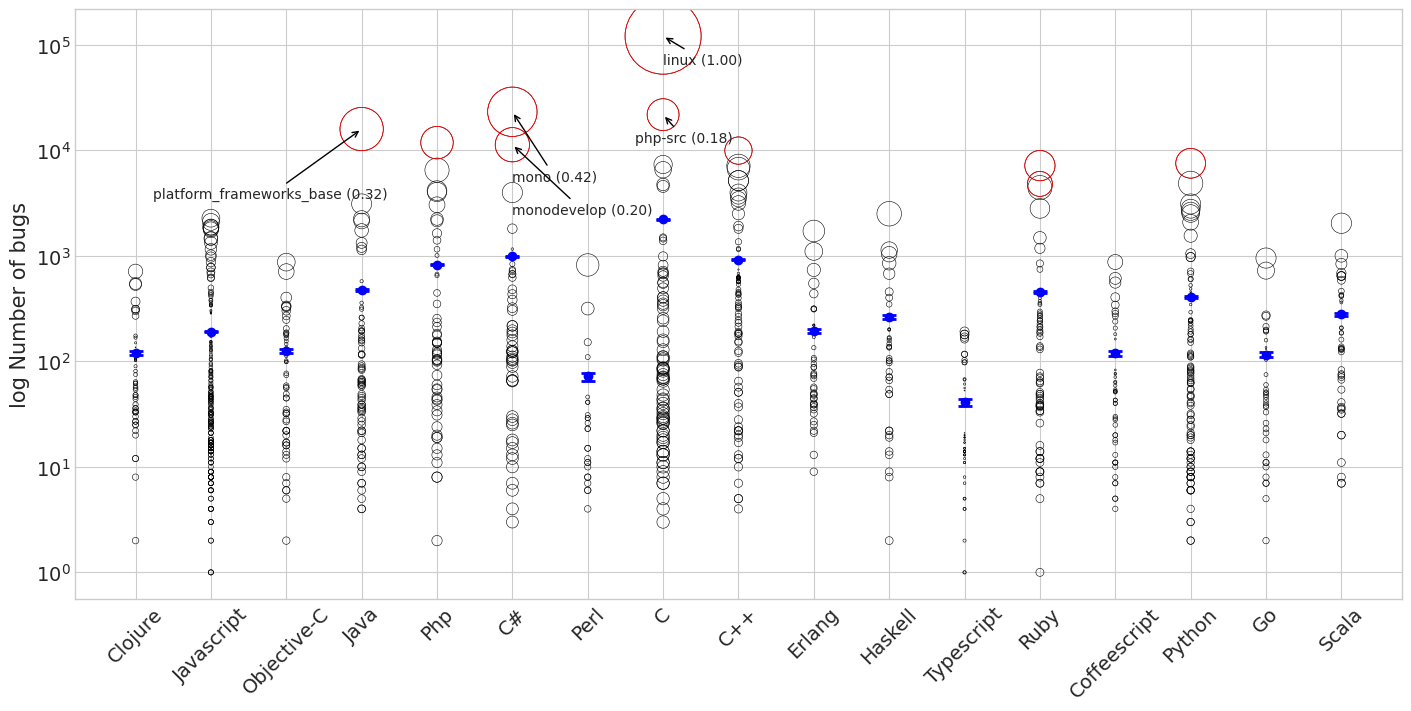

In [178]:
#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h1 /= pareto_k_h1.max()
pareto_k_h1_size = 3000 * pareto_k_h1

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h1)[-10:][::-1]
top_data_points = df.iloc[top_indices]

#compute error bars of 95 HDI
hdi = az.hdi(post_pred_h1)
lower_bound, upper_bound = hdi.data_vars["lambda"].to_numpy()[:,0], hdi.data_vars["lambda"].to_numpy()[:,1]
diffs = upper_bound - lower_bound  

fig, axes = plt.subplots(figsize=(14,7))
axes.set_yscale("log")

axes.errorbar(x_seq, post_pred_h1_mean, yerr=diffs, fmt='o', color='b', ecolor='b', capsize=5, capthick=2)
axes.scatter(df.language, df.bugs, s = pareto_k_h1_size, facecolors='none', edgecolors='k', lw=0.4)
axes.scatter(top_data_points.language, top_data_points.bugs, s = pareto_k_h1_size[top_indices], facecolors='none', edgecolors='r', lw=0.6)
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
axes.set_ylabel("log Number of bugs")
axes.set_xticks(ticks=ticks)
axes.set_xticklabels(labels=languages, rotation=45)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    # print(row)
    dont_annotate = False
    if row['language'] == 7 and row['project'] == 'linux':
        position=(0,-20)
    elif row['language'] == 1:
        position=(-70,15)
    elif row['language'] == 5:
        position=(0,-50)
    elif row['language'] == 7 and row['project'] == 'php-src':
        position=(-20,-20)
    elif row["language"] == 3:
        position = (-150,-50)
    else:
        dont_annotate = True
    if dont_annotate == False:
        axes.annotate(f"{row['project']} ({pareto_k_h1[index]:.2f})", xy=(row['language'], row['bugs']), xytext=position,textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.show()


As seen above, the 10 projects with the greatest `PSIS` values, have been plotted in red. Below is a plot showing, the predictions but without each these 10 influential datapoints.

/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


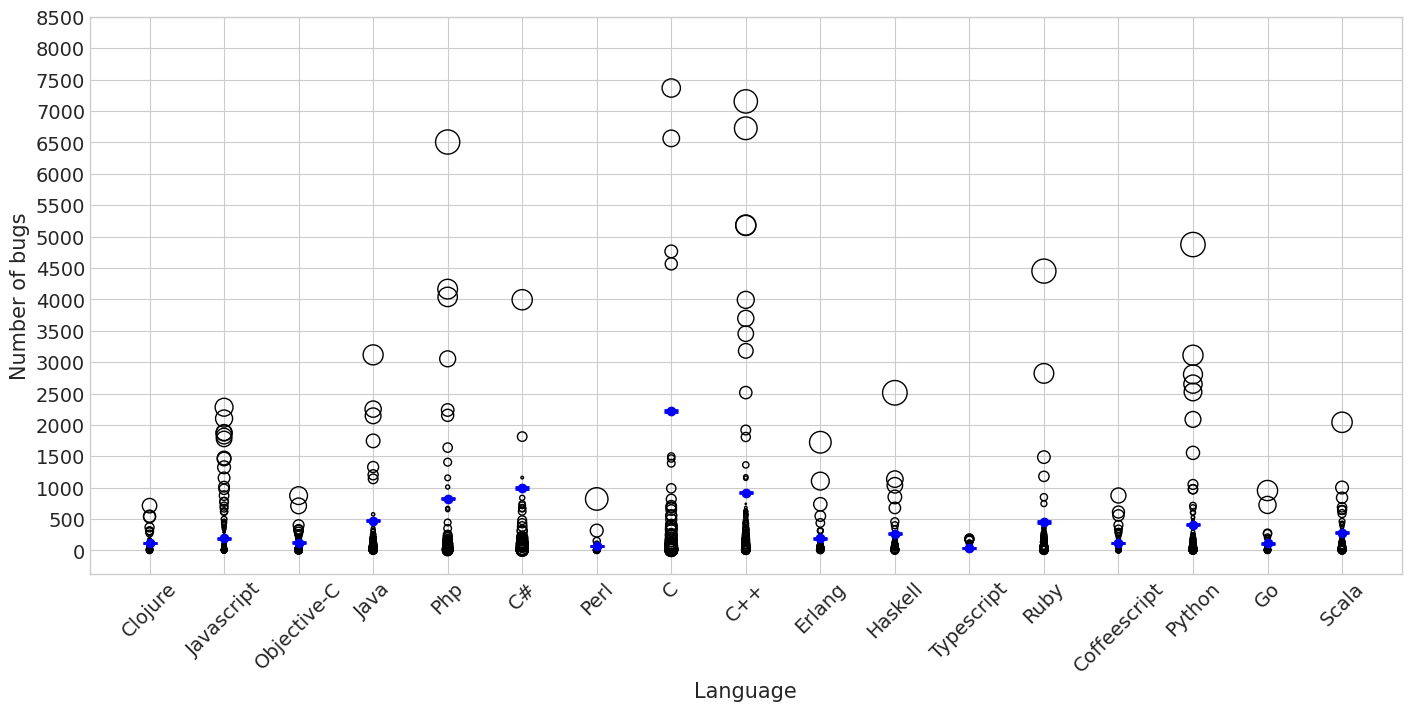

In [179]:
fig,axes = plt.subplots(figsize=(14,7))

pareto_k_size_without_top = np.delete(pareto_k_h1_size, top_indices)
df_without_top = df.drop(top_indices)

axes.errorbar(x_seq, post_pred_h1_mean, yerr=diffs, fmt='o', color='b', ecolor='b', capsize=5, capthick=2)
axes.scatter(df_without_top.language, df_without_top.bugs, facecolors='none', s=pareto_k_size_without_top, edgecolors='k', lw=1)
axes.set_xlabel('Language')
axes.set_ylabel('Number of bugs')
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
axes.set_xticks(ticks=ticks)
axes.set_xticklabels(labels=languages, rotation=45)
plt.yticks(np.arange(0, 9000, 500));

From the plotted HDI interval of the Poisson Estimator, multiple languages seem to have an expected number of bugs somewhere between 0 and 500. From the plot it is not clear which of the posterior distributions of $\lambda_L = $ **Expected Counts of Bugs** is the smallest. Specifically we are interested in whether programming in Haskell language yields the smallest probability to bugs given the model parameters and the data. 
To explore this, we look at the numerical estimates of the posterior $\lambda_L$ means.
Secondly, we plot the Kernel Density Estimates from each of the top 5 $\lambda_L$ posterior distributions that yields the highest probability to the smallest number of bugs. This plot is also extended with the Haskell Kernel Density Estimate for comparison.

In [180]:
seaborn_plot_data

lambdas      language
11    40.885663    Typescript
6     72.116316          Perl
15   115.874085            Go
13   119.456842  Coffeescript
0    120.249670       Clojure
2    125.000872   Objective-C
1    192.081525    Javascript
9    193.329506        Erlang
10   264.782364       Haskell
16   281.216150         Scala
14   408.220530        Python
12   452.865991          Ruby
3    473.458577          Java
4    826.638257           Php
8    920.651137           C++
5    993.009425            C#
7   2223.724282             C

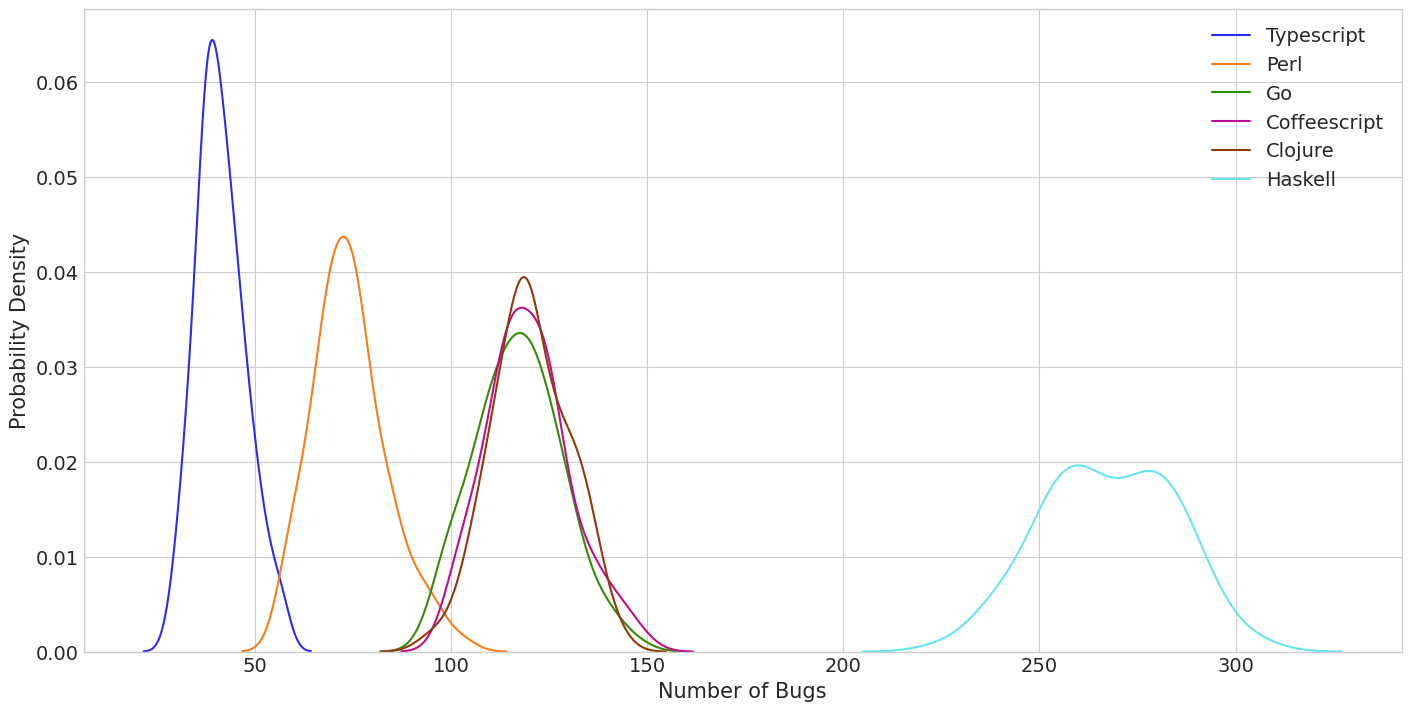

In [234]:
seaborn_plot_data = pd.DataFrame({"lambdas": post_pred_h1_mean, "language": languages})
seaborn_plot_data.sort_values("lambdas", ascending=True, inplace=True)
_, axes = plt.subplots(figsize=(14, 7))


#Generating Poisson data
for language, expected_count in zip(seaborn_plot_data["language"].to_list()[:5], seaborn_plot_data["lambdas"].to_list()[:5]):
    sample = poisson.rvs(mu=expected_count, size=100)
    sns.kdeplot(x=sample, fill=False, label=f'{language}', ax=axes)

sample = poisson.rvs(seaborn_plot_data[seaborn_plot_data["language"]=="Haskell"]["lambdas"], size=100)
sns.kdeplot(x=sample, fill=False, label="Haskell", ax=axes)

axes.set_xlabel('Number of Bugs')
axes.set_ylabel('Probability Density')
plt.legend()
plt.show()

Based on the above results, we can see that Haskell is not in the top 5 lowest estimated posterior expected count values, so based on these results we reject H1. The programming language that would fulfill that hypothesis based on this poisson regression would be Typescript with its $\lambda = 40.885663 = 41$ expected bugs for an average project. This is also seen from the posterior mean of $\beta_{typescript} = -0.0982$, indicating that there is a negative impact on the $log(\lambda)$ by $0.0982$ when programming in Typescript

### Can we model this in any other way?

As of now we have only modelled the probability of the least amount of bugs among all programming languages with a poisson regression to which H1 is rejected. The danger for a GLM poisson regression with this dataset is that if a certain language is used in larger projects in terms of commits, the model will pick up on some false relationships between languages and the number of bugs, simply because the language has been used in projects with many bugs. This hypothesis could also be modelled by a **binomial regression**, where the probability $p$ of a success - a bug - is modelled by $k$ number of successes in the *bugs* variable in $N$ number of tries in the variable *Commits*.

Now follows the same procedure as above, to see if it has any effects on the outcome of the experiment. 

## Binomial Regression

The model includes an $\alpha_L$ to see the average effect of a language on the probability of a bug.

\begin{align*}
B_i \sim & \; \mathrm{Binomial}(N_i, p_i)\\
\mathrm{logit}(p_i) = & \; \alpha_{L}\\
\alpha_L \sim & \; \text{Not determined yet} \\
\end{align*}



We got inspiration for prior predictive checks from lecture $09$.
Here it is important to stress, that the probability mass for the outcome variable $p_i$ has to be as evenly distributed between $(0,1)$, such that the prior assumption is neither only successes or only failures for each independent bernoulli trial of commits.

### Prior Predictive Checks

Using the inspiration from lecture 9, we show the prior assumptions from two Normal priors with for $\alpha$ one standard normal $N(\mu=0,\sigma=2)$ and one with a larger value for $\sigma=5$

In [195]:
with pm.Model() as standard_binomial_prior:

    alpha = pm.Normal("alpha", mu=0, sigma=2)
    p = pm.Deterministic("p", pm.math.invlogit(alpha))
    y_i = pm.Binomial("y", n=1, p=p, observed=df.bugs)

with pm.Model() as sigma_binomial_prior:

    alpha = pm.Normal("alpha", mu=0, sigma=5)
    p = pm.Deterministic("p", pm.math.invlogit(alpha))
    y_i = pm.Binomial("y", n=1, p=p, observed=df.bugs)

prior_standard  = pm.sample_prior_predictive(model=standard_binomial_prior).prior
prior_sigma = pm.sample_prior_predictive(model=sigma_binomial_prior).prior

Sampling: [alpha, y]
Sampling: [alpha, y]


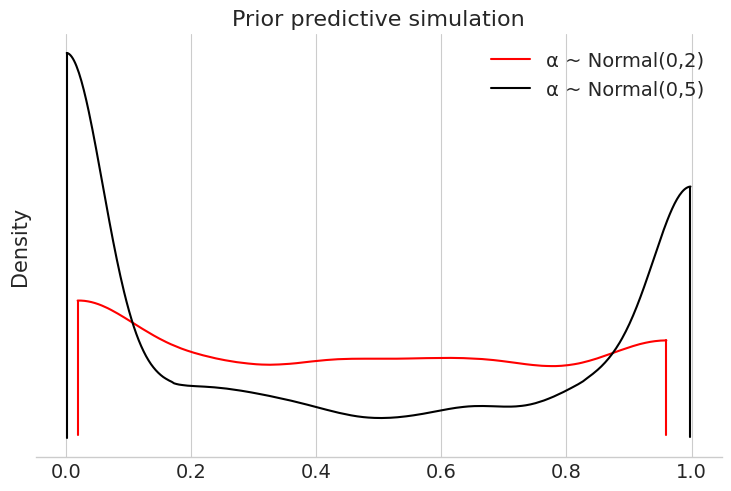

In [196]:
az.plot_density(
    [prior_standard["p"], prior_sigma["p"]],
    data_labels=['α ~ Normal(0,2)','α ~ Normal(0,5)'],
    colors=['red','black'],point_estimate=None)
plt.title('Prior predictive simulation')
# plt.xlabel('Prior prob pull left, i.e., p')
plt.ylabel('Density');

We will chose the standard normal as the prior for $\alpha_L$

$$\alpha_L \sim N(0,2)$$



### Model Fitting

We fit the following model:

\begin{align*}
B_i \sim & \; \mathrm{Binomial}(N_i, p_i)\\
\mathrm{logit}(p_i) = & \; \alpha_{L}\\
\alpha_L \sim & \; N(0,2) \\
\end{align*}


In [125]:
with pm.Model() as h1_binomial_model:
      #Data
      language = pm.Data("language", df.language, mutable=True)
      
      # Priors
      alpha = pm.Normal("alpha", mu=0, sigma=2, shape=len(languages))
      
      #f(theta , x)
      p = pm.Deterministic("p", pm.math.invlogit(alpha[language]))

      # likelihood
      y_i = pm.Binomial("y", n=df.commits, p=p, observed=df.bugs)
      h1_binomial_trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.


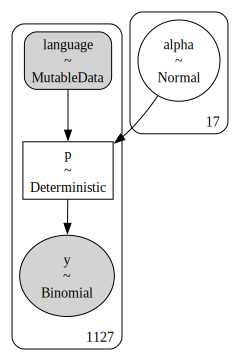

In [221]:
pm.model_to_graphviz(model=h1_binomial_model)

The trace summary looks valid in estimating the posterior distributios of the probability of a bug for a given datapoint, since the `r_hat` for all parameters are $1.0$. Additionally the `mcse_mean` and `mcse_sd` indicate that both samplings from the mode of the posterior could be done successfully. 

In [220]:
pm.summary(h1_binomial_trace, var_names=["alpha"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]  -1.31  0.01   -1.34    -1.28        0.0      0.0  15286.12   
alpha[1]  -0.69  0.01   -0.71    -0.68        0.0      0.0  17492.81   
alpha[2]  -0.72  0.01   -0.75    -0.69        0.0      0.0  14900.82   
alpha[3]  -0.39  0.01   -0.40    -0.37        0.0      0.0  17205.42   
alpha[4]  -0.41  0.01   -0.42    -0.40        0.0      0.0  15308.00   
alpha[5]  -0.52  0.01   -0.53    -0.51        0.0      0.0  15484.50   
alpha[6]  -0.58  0.03   -0.63    -0.52        0.0      0.0  16618.25   
alpha[7]  -0.37  0.00   -0.38    -0.37        0.0      0.0  14369.99   
alpha[8]  -0.39  0.00   -0.40    -0.38        0.0      0.0  14945.26   
alpha[9]  -1.05  0.01   -1.08    -1.03        0.0      0.0  15616.80   
alpha[10] -1.24  0.01   -1.26    -1.22        0.0      0.0  17017.87   
alpha[11] -1.65  0.02   -1.70    -1.61        0.0      0.0  15405.08   
alpha[12] -1.10  0.01   -1.11    -1.08        0.0      0.0  16422.90   
alpha[13] -0.94  0.01   -0.97    -0.92        0.0      0.0  17444.92   
alpha[14] -0.53  0.01   -0.55    -0.52        0.0      0.0  15492.35   
alpha[15] -1.24  0.02   -1.27    -1.21        0.0      0.0  15321.65   
alpha[16] -1.19  0.01   -1.21    -1.18        0.0      0.0  18189.11   

           ess_tail  r_hat  
alpha[0]    6375.54    1.0  
alpha[1]    6173.30    1.0  
alpha[2]    5791.29    1.0  
alpha[3]    5689.98    1.0  
alpha[4]    5860.01    1.0  
alpha[5]    6589.43    1.0  
alpha[6]    6173.94    1.0  
alpha[7]    5864.40    1.0  
alpha[8]    5509.40    1.0  
alpha[9]    5867.83    1.0  
alpha[10]   6027.38    1.0  
alpha[11]   6044.07    1.0  
alpha[12]   6158.62    1.0  
alpha[13]   6120.45    1.0  
alpha[14]   5777.93    1.0  
alpha[15]   5889.14    1.0  
alpha[16]   5804.13    1.0

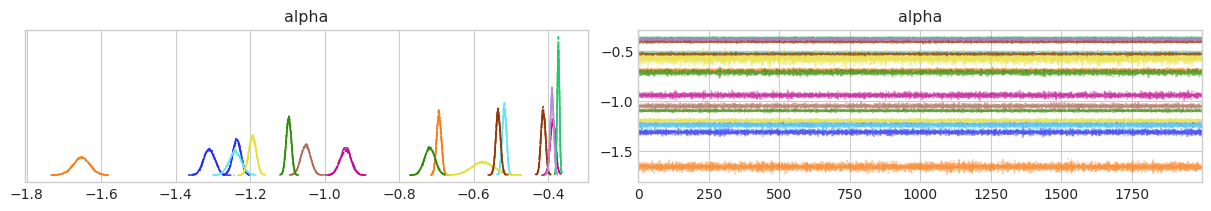

In [223]:
pm.plot_trace(h1_binomial_trace, var_names=['alpha']);

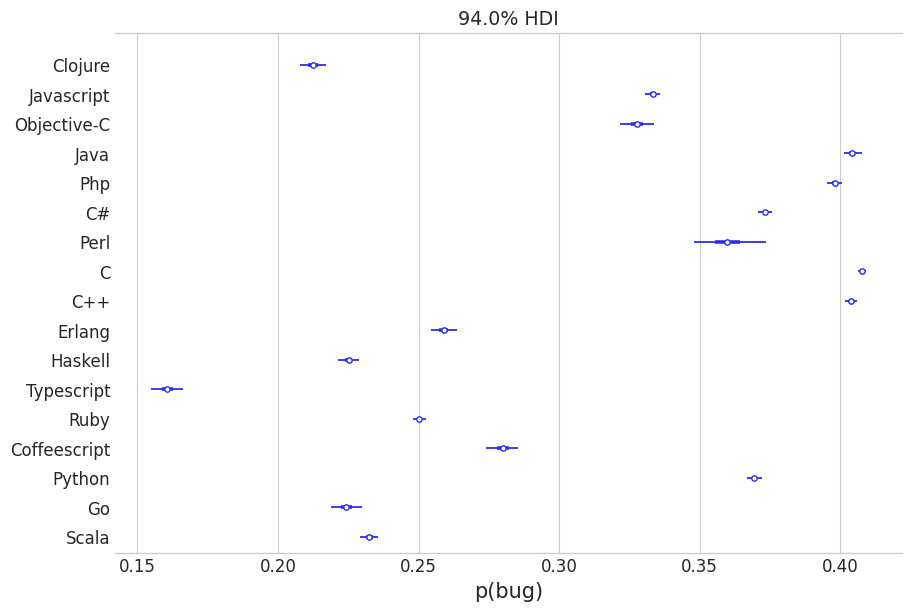

In [232]:
_, ax = plt.subplots(figsize=(9,6))
az.plot_forest(h1_binomial_trace, var_names=["alpha"], ax=ax, combined=True,legend=True, textsize=12.0, transform=expit);
forest_languages = [int(i.get_text()[1:-1]) if len(i.get_text()) < 6 else 0 for i in ax.get_yticklabels()]
ax.set_xlabel("p(bug)"); 
ax.set_yticklabels(languages.take(forest_languages)); 

Based on the above forest plot, the binomial regression shows similar results as the poisson regression, in particular we see that the language `C` has the highest estimated probability of a bug. Similarly, `Typescript` has the smallest estimated probability of bug, which aligns with the poisson regression. Contrary to the poisson regression where ´Haskell´ was 8th ranked language in terms of least number of bugs, it has now moved to being the language with the 4'th least probability of a bug.

We also compare the poisson and the binomial model using information criteria. We note that the binomial model has a better fit (and is not overfit) than the poisson.   

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:249: RuntimeWarning: divide by zero encountered in log
  score += np.log(np.dot(exp_ic_i[i], w_full))
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:256: RuntimeWarning: invalid value encountered in scalar divide
  grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

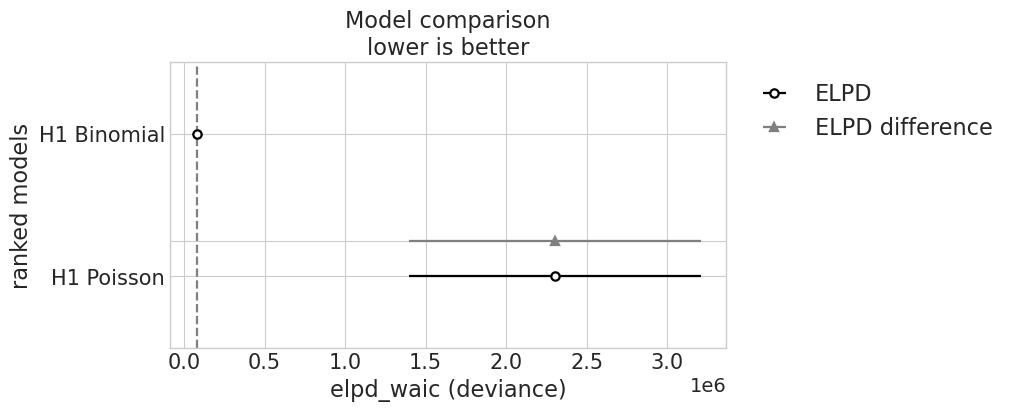

In [127]:
comp = pm.compare({'H1 Poisson': h1_poisson_trace,
            'H1 Binomial': h1_binomial_trace}, 
            ic='waic', scale='deviance')

pm.plot_compare(comp, insample_dev=False, figsize=(10,4))

In [128]:
comp

rank     elpd_waic         p_waic     elpd_diff  weight  \
H1 Binomial     0  8.151003e+04    4871.683124  0.000000e+00     0.5   
H1 Poisson      1  2.301345e+06  121553.688607  2.219835e+06     0.5   

                        se            dse  warning     scale  
H1 Binomial   12364.637201       0.000000     True  deviance  
H1 Poisson   907395.782060  905693.211698     True  deviance

#### Conclusion H1

Based on the results from the poisson and the binomial regression models, we reject H1. `Haskell` does **neither** give the highest probability to the lowest number of bugs **nor** does it give the smallest probability to a bug given a commit. Meaning `Haskell` is not less prone to containing bugs than other languages based on our results. It was in fact `Typescript` that gave the highest probability to the lowest number of bugs.

## H2 (Poisson Regression)

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

We model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $\lambda$ to the predictors. We use standardized Age $A$ as a continious predictor. We also add an intercept $\alpha$. When using standardized age, $\alpha$ corresponds to the $ln(\lambda)$ when age is equal to mean age. 

$$
log(\lambda_i) = \alpha + \beta_{A}A_i
$$

We re-use the prior for $\alpha$ from H1:

$$
\alpha \sim N(6,1.5)
$$

The prior for  $\beta_{A}$ is not yet defined. In the following sections we determine a reasonable prior

$$
\beta_{A} \sim \text{Not determined yet}
$$

#### Determine prior for $\beta_A$ 

Next, we determine the prior for $\beta_A$.

We simulate the effect of varying the prior for $\beta_{A}$ by sampling N alphas with the fixed prior that we determined earlier, and sampling N betas where we can vary the prior.

We then plot the effect of $\beta_{A}$ by varying standardized age from -3 to 3, corresponding to 3 standard deviations below and above the mean of age. We can then see how strong (or not strong) the prior effect of $\beta_{A}$ on number of bugs is.

In [9]:
#Inspiration from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

def plot_prior_continuous(b_mean: int = 0, b_std: int = 0, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.normal(b_mean, b_std, N)
    
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    
    for a, b in zip(alphas, betas):
        plt.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    plt.xlabel("Age (std)")
    plt.ylabel('Number of bugs')
    
    return plt

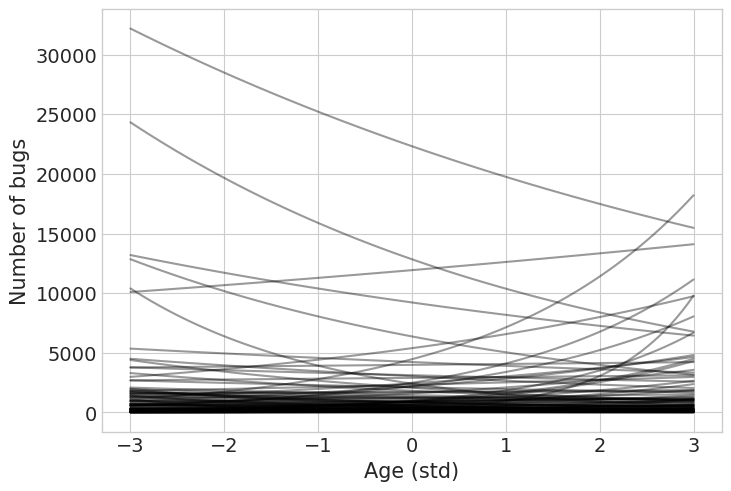

In [66]:
plot_prior_continuous(0, 0.3);

These effects of age seem plausible, and they allow for high values in number of bugs. They also allow for both positive and negative impact of age on the number of bugs. Many of them are rather flat, representing a conservative prior, meaning that we dont expect a particular direction of the effect of age. But we also dont expect explosive or unrealistic effects of age. 


We determine the prior to be $\beta_A \sim N(0, 0.3)$

#### Fit model

We fit the following model:

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

$$
log(\lambda_i) = \alpha + \beta_{A}A_i
$$


$$
\alpha \sim N(6,1.5)
$$


$$
\beta_{A} \sim N(0, 0.3)
$$

In [67]:
with pm.Model() as h2_poisson_model:
    #Priors  
    alpha = pm.Normal('alpha', mu=6, sigma=1.5)
    beta_age = pm.Normal('beta_age', mu=0, sigma=0.3)

    #We add age_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)

    #Compuate lambda and sample number of bugs
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
        
    #Sample posterior and prior predictive
    h2_poisson_trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.


The model has a single estimate for $\alpha$ and $\beta_A$. Together with standardized age, they determine $1.127$ $\lambda$ and $B$, one for each observation of a combination of project/language.

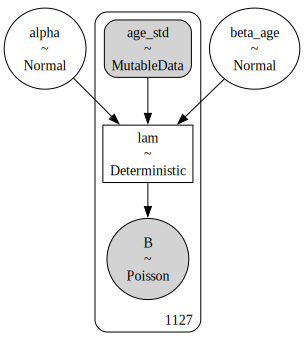

In [68]:
pm.model_to_graphviz(h2_poisson_model)

Below is the trace convergence for the parameters `alpha` and `beta_age`.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.


We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have a good mixing. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 2 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [69]:
pm.summary(h2_poisson_trace, var_names=['alpha', 'beta_age'],round_to=2)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha     6.08  0.0    6.08     6.09        0.0      0.0   6756.47   5799.61   
beta_age  0.34  0.0    0.34     0.34        0.0      0.0   6470.78   5573.27   

          r_hat  
alpha       1.0  
beta_age    1.0

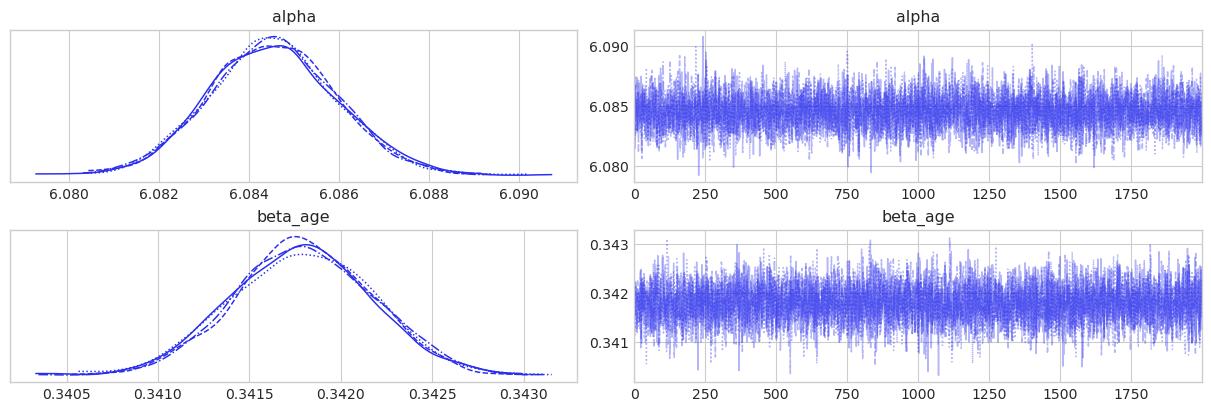

In [70]:
az.plot_trace(h2_poisson_trace, var_names = ['alpha','beta_age']);

The forest plot shows that the standard deviations for the estimates for both `alpha` and `beta_age` are very small. We also note that the effect of `alpha` is much larger than the effect of `beta_age`.

The posterior mean of `alpha` is close to the prior we defined $N(6, 1.5)$, but it has become a lot more confident - it has a posterior sd of 0.0014.

The posterior mean `beta_age` has moved in positive direction from its prior of $N(0, 0.3)$. The posterior sd is a lot more confident than the prior sd.

In [71]:
pm.summary(h2_poisson_trace, var_names=['alpha', 'beta_age'],round_to=4)[['mean', 'sd']]

mean      sd
alpha     6.0845  0.0014
beta_age  0.3418  0.0004

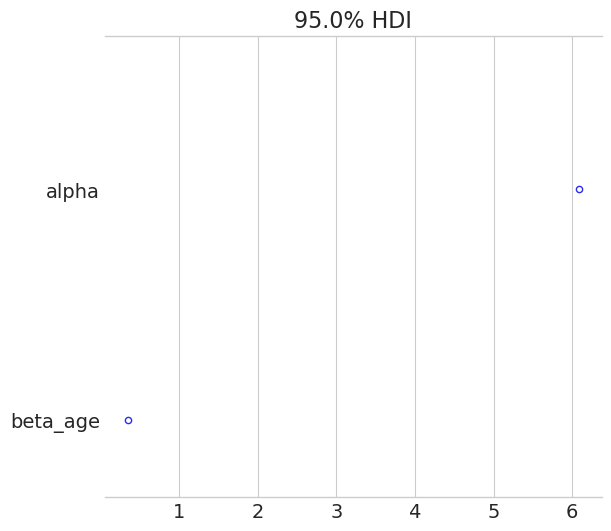

In [72]:
az.plot_forest(h2_poisson_trace, var_names = ['alpha', 'beta_age'], hdi_prob=.95, combined=True);

#### Posterior Predictive Check

Next we use the posterior estimates to make posterior predictive check and see how the model fits the data.

We calculate pareto k values for the data-points, to see which are influential ones. We get a warning that some samples have a pareto k value higher than $0.7$, and are therefore considered highly influential. 

In [21]:
pareto_k_h2 = az.loo(h2_poisson_trace, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


We sample $1.127$ points with equal spacing from values between $-1.5$ and $14$ (corresponding to min/max age std.), and use these to sample the posterior predictive estimates.

In [22]:
print(f"Min age std: {df.age_std.min():.2f}")
print(f"Max age std: {df.age_std.max():.2f}")

Min age std: -1.14
Max age std: 13.29


In [34]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq_std = np.linspace(-1.5, 13, n_points)
x_seq = x_seq_std * df['age'].std() + df['age'].mean()  # Convert to original age scale


with h2_poisson_model:
    pm.set_data({"age_std": x_seq_std})
    post_pred_h2 = pm.sample_posterior_predictive(h2_poisson_trace, var_names=["B"])['posterior_predictive']['B']
    
post_pred_h2_mean = post_pred_h2.mean(["chain", "draw"])

Sampling: [B]


Number of points sampled: 1127


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


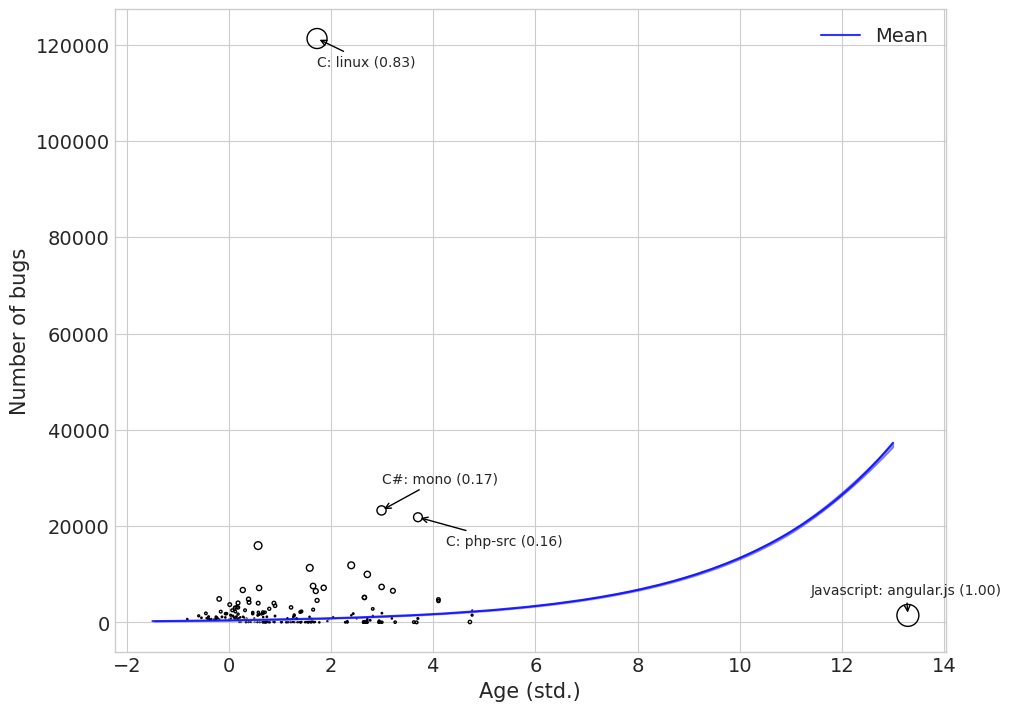

In [56]:
_, ax = plt.subplots(figsize=(10,7))

#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h2 /= pareto_k_h2.max()
pareto_k_h2_size = 250 * pareto_k_h2

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h2)[-10:][::-1]
top_data_points = df.iloc[top_indices]

az.plot_hdi(x_seq_std, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=ax)
ax.plot(x_seq_std, post_pred_h2_mean, color = 'b', alpha=0.8, label='Mean')
ax.scatter(df.age_std, df.bugs, s = pareto_k_h2_size, facecolors='none', edgecolors='k', lw=1)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    dont_annotate = False
    if row['language'] == 7 and row['project'] == 'linux':
        position=(0,-20)
    elif row['language'] == 1:
        position=(-70,15)
    elif row['language'] == 5 and row['project'] == 'mono':
        position=(0,20)
    elif row['language'] == 7 and row['project'] == 'php-src':
        position=(20,-20)
    else:
        dont_annotate = True
    if dont_annotate == False:
        ax.annotate(f"{languages[row['language']]}: {row['project']} ({pareto_k_h2[index]:.2f})", xy=(row['age_std'], row['bugs']), xytext=position,
                    textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax.legend();
ax.set_xlabel('Age (std.)');
ax.set_ylabel('Number of bugs');

What jumps out of this figure is the existance of very influential data-points. In particular *C: Linux* which has many more bugs for its age compared to the other data-points, and *Javascript: angular.js* which is an old project/language but still has few bugs. It is important to note that we should not discard these data-points.

However, to better vizualise the posterior predictions we "zoom in" on the data-points by removing the influential data-points from the figure.

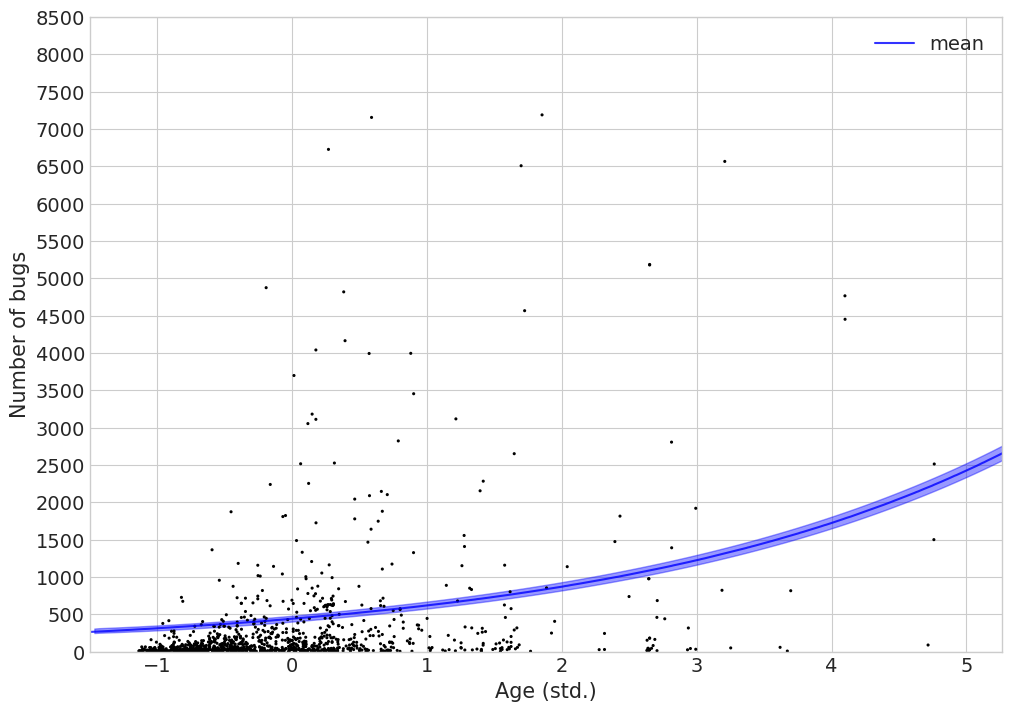

In [57]:
plt.figure(figsize=(10,7))

pareto_k_size_without_top = np.delete(pareto_k_h2_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq_std, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq_std, post_pred_h2_mean, color = 'b', alpha=0.8, label='mean')
plt.scatter(df_without_top.age_std, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(-1.5, max(df_without_top.age_std)+0.5)
plt.ylim(0,8500)
plt.xlabel('Age (std.)')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

We see a positive effect of age, which was also reflected in the posterior estimate of `beta_age` which was 0.34. In addition we see that the number of bugs is around 450 when standardized age is 0. This is given by the `alpha` = 6.08 which corresponds to $exp(6.08) = 437$.

The plot also shows small uncertainty of the mean, although the uncertainty grows slighly as standardized age increases. 

Next we plot the effect of non-standardized age, also excluding the most influential data-points. We assume that the unit for age is days.

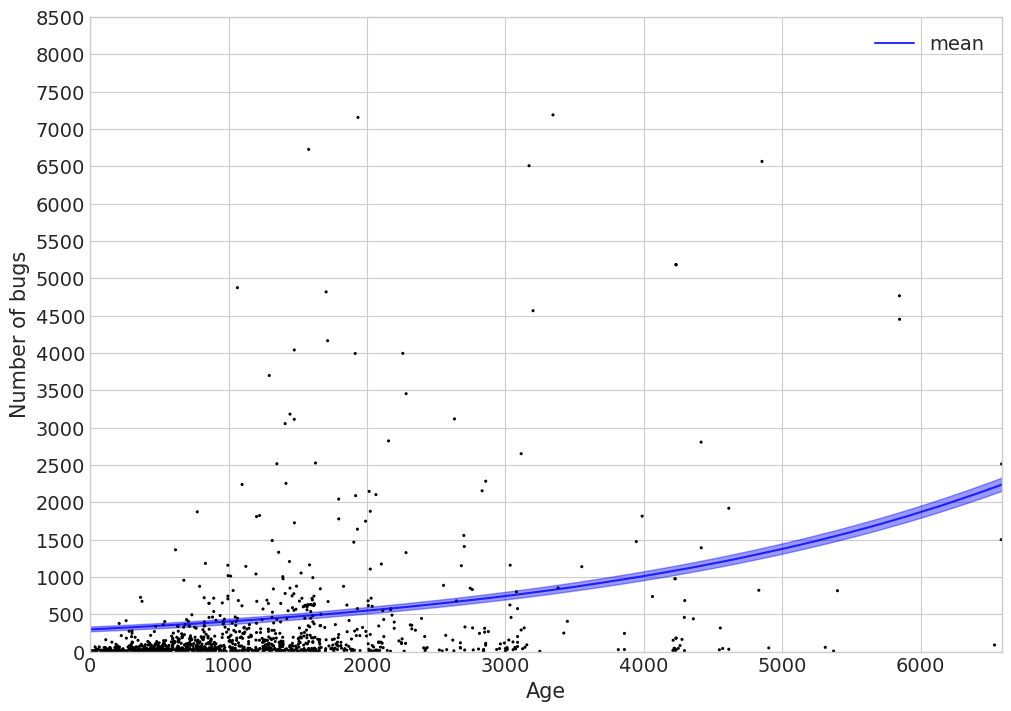

In [58]:
plt.figure(figsize=(10,7))

pareto_k_size_without_top = np.delete(pareto_k_h2_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h2_mean, color = 'b', alpha=0.8, label='mean')
plt.scatter(df_without_top.age, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(-1.5, max(df_without_top.age)+0.5)
plt.ylim(0,8500)
plt.xlabel('Age')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

We note that the intercept of the model seems unrealistic. The model expects that a project/language of age 0 will have 297 bugs. This is a pitfall of using an intercept ($\alpha$) in a Poisson model as a free parameter which does not reflect the natural zero of an unstarted project where age and bugs are both $0$.  

In [59]:
y_at_0 = np.interp(0, x_seq, post_pred_h2_mean)
y_at_365 = np.interp(365, x_seq, post_pred_h2_mean)
y_at_1825 = np.interp(1825, x_seq, post_pred_h2_mean)
print(f"Expected number of bugs at 0 days: {y_at_0:.2f}")
print(f"Expected number of bugs at 365 days: {y_at_365:.2f}")
print(f"Expected number of bugs at 1825 days: {y_at_1825:.2f}")

Expected number of bugs at 0 days: 296.61
Expected number of bugs at 365 days: 331.61
Expected number of bugs at 1825 days: 518.62


#### Conclusion H2

Based on the above results, we find that age has a positive impact on number of bugs, thereby confirming hypothesis 2. A project/language with older age have a larger number of bugs. An increase in age from 365 days (1 year) to 1825 days (5 years) increases the expected number of bugs from 332 to 519. We consider this a rather modest effect. 

However, we suspect that the association of age with bugs could be a result of omitted variable bias. In hypothesis 3 we examine whether stratifying by commits will lower the strength of the association with age on bugs.

It is also important to note that this model, which only includes a single effect of age on bugs does not model the effect of age for each individual language. The model assumes that all languages can be modelled together and that there is an overall effect of age on bugs. 

## H3 (Poisson Regression)

* **H3** - Number of commits (C) does not impact the effect of age (A) on the number of bugs (B) for any programming language (L). That is, the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

In hypothesis 3 we examine whether the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

We treat commits as a confounding variable that is affecting age and bugs through a "fork-effect".

In hypothesis 2 we saw that age (X) was associated with bugs (Y). In hypothesis 3 we strafiy by commits (Z) and examine whether the effect of age changes compared to hypothesis 2. To stratify by commits we simply add it as a predictor in the linear combination. 

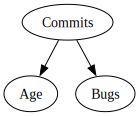

In [62]:
CausalGraphicalModel(
    nodes=["Commits", "Bugs", "Age"],
    edges=[
        ("Commits", "Bugs"), 
        ("Commits", "Age"), 
    ]
).draw()

As before we model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $\lambda$ to the predictors. We use standardized Age $A$ and standardized commits $C$ as a continuous predictors. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i + \beta_{C}C_i
$$

We re-use the priors for $\alpha$ and  $\beta_A$ that we determined in H2.

$$
\alpha \sim N(6, 1.5)
$$

$$
\beta_A \sim N(0, 0.3)
$$

We determine the prior for $\beta_{C}$ in the following section.

$$
\beta_C \sim \text{Not yet determined}
$$

#### Determine prior for $\beta_C$ 

We use standardized commits, which makes the coefficients easier to interpret, while also allowing us to remove the effect of commits in the posterior predictive check.


In the prior for $\beta_A$ we allowed for both positive and negative impact of age on the number of bugs, with many priors being quite flat.

We dont want the same behavior in the prior for the effect of number of commits on number of bugs: $\beta_C$. This is because we know that bugs is defined as the number of commits classified as bugs. This means that commits can *not* have a negative impact on the number of bugs. This is simply impossible. So we want a prior for $\beta_C$ that only allows positive relationships.

We choose to use a log-normal distribution for $\beta_C$ which only has positive values.

In [63]:
def plot_prior_continuous_lognormal(b_mean: float = 0, b_std: float = 0, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.lognormal(mean=b_mean, sigma=b_std, size=N)
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    
    for a, b in zip(alphas, betas):
        plt.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    plt.xlabel("commits (std)")
    plt.ylabel('Number of bugs')
    
    return plt

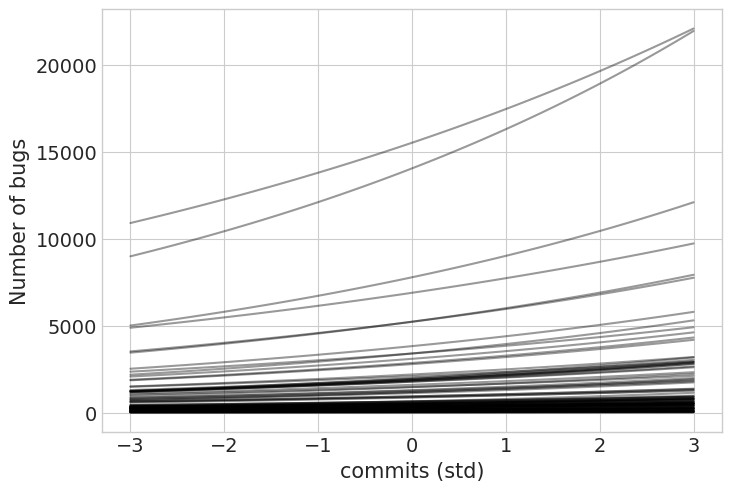

In [64]:
plot_prior_continuous_lognormal(b_mean=-2, b_std=0.1);

These effects of commits seem plausible. They are all positive, and some of them allow for quite strong relationships.

We determine the prior to be $\beta_C \sim \text{LogNormal}(-2, 0.1)$.

#### Fit model

We fit the model using the determined priors:

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

$$
log(\lambda_i) = \alpha + \beta_{A}A_i
$$


$$
\alpha \sim N(6,1.5)
$$


$$
\beta_{A} \sim N(0, 0.3)
$$

$$\beta_C \sim \text{LogNormal}(-2, 0.1)$$

In [73]:
with pm.Model() as h3_poisson_model:
    #Priors  
    alpha = pm.Normal('alpha', mu=6, sigma=1.5)
    beta_age = pm.Normal('beta_age', mu=0, sigma=0.3)
    beta_commits = pm.Lognormal('beta_commits', mu=-2, sigma=0.1)

    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    commits_std = pm.Data("commits_std", df.commits_std, mutable=True)

    #Compuate lambda and sample number of bugs
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_commits*commits_std + beta_age*age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
        
    #Sample posterior and prior predictive
    h3_poisson_trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_commits]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


The model has a single estimate for $\alpha$, $\beta_A$ and $\beta_C$ . Together with standardized age and commits, they determine $1.127$ $\lambda$ and $B$, one for each observation of a combination of project/language.

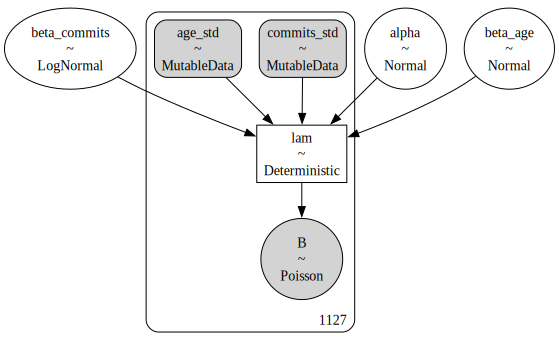

In [74]:
pm.model_to_graphviz(h3_poisson_model)

Below is the trace convergence for the parameters `alpha`,  `beta_age`, and `beta_commits`

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation.

We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 3 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [75]:
pm.summary(h3_poisson_trace, var_names=['alpha', 'beta_age', 'beta_commits'],round_to=2)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha         5.82  0.0    5.81     5.82        0.0      0.0   5626.80   
beta_age      0.33  0.0    0.33     0.33        0.0      0.0   7079.39   
beta_commits  0.17  0.0    0.17     0.17        0.0      0.0   5466.07   

              ess_tail  r_hat  
alpha          5919.89    1.0  
beta_age       5048.55    1.0  
beta_commits   5592.32    1.0

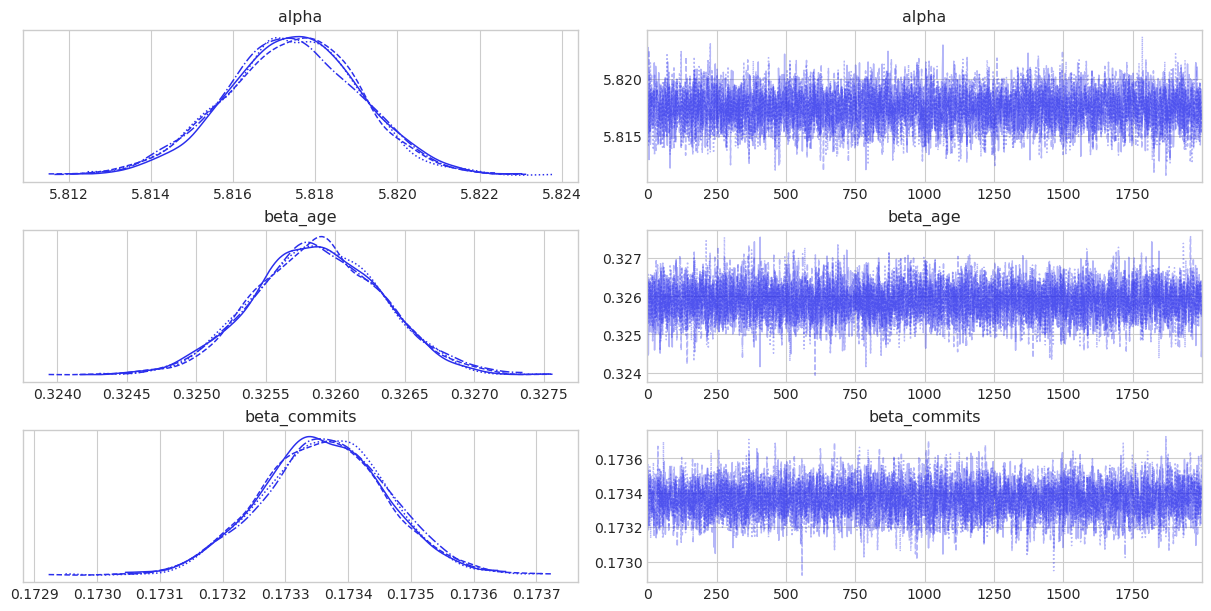

In [77]:
az.plot_trace(h3_poisson_trace, var_names = ['alpha','beta_age', 'beta_commits']);

The forest plot below shows that the standard deviations for the estimates for `alpha`, `beta_age`, and `beta_commits` are very small. We also note that `alpha` is much larger than `beta_age` and `beta_commits`.

Contrary to what we expected, `beta_age` actually has a larger effect than `beta_commits`. We expected `beta_commits` to have a larger effect because it is closely associated with number of bugs (bugs is defined as the number of commits classified as a bug). 

In [80]:
pm.summary(h3_poisson_trace, var_names=['alpha', 'beta_age', 'beta_commits'],round_to=4)[['mean', 'sd']]

mean      sd
alpha         5.8174  0.0016
beta_age      0.3259  0.0005
beta_commits  0.1734  0.0001

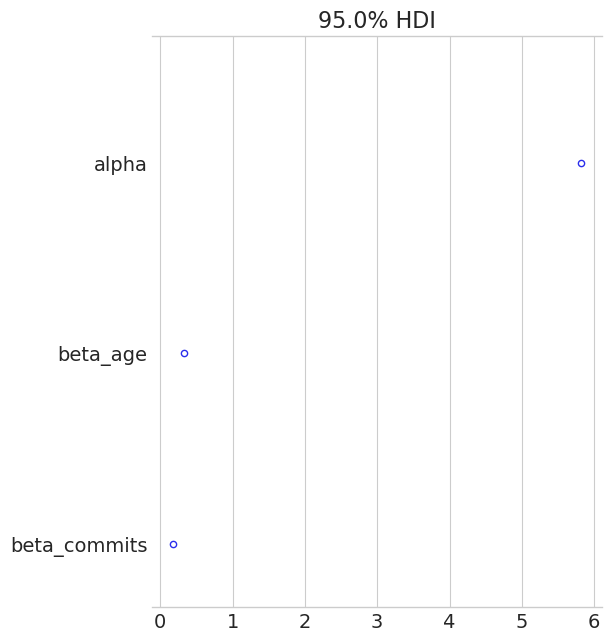

In [82]:
az.plot_forest(h3_poisson_trace, var_names = ['alpha','beta_age', 'beta_commits'], hdi_prob=.95, combined=True);

Next we compare the effect of age on number of bugs without conditioning on the number of commits (H2) and with conditioning on the number of commits (H3). 

We see a notable difference between the effect of age in the two models in the forest plot. The effect of age on the number of bugs conditioned by the number of commits is confidently lower than the direct effect of age. 

Nonetheless, the difference seems quite small when looking at the estimates. It will be easier to compare them in the next section of posterior predictions.

In [84]:
print(f"Decrease in posterior mean of beta_age from H2 to H3: {round(pm.summary(h3_poisson_trace, var_names=['beta_age'],round_to=4)['mean'].values[0]-pm.summary(h2_poisson_trace, var_names=['beta_age'],round_to=4)['mean'].values[0], 4)}")

Decrease in posterior mean of beta_age from H2 to H3: -0.0159


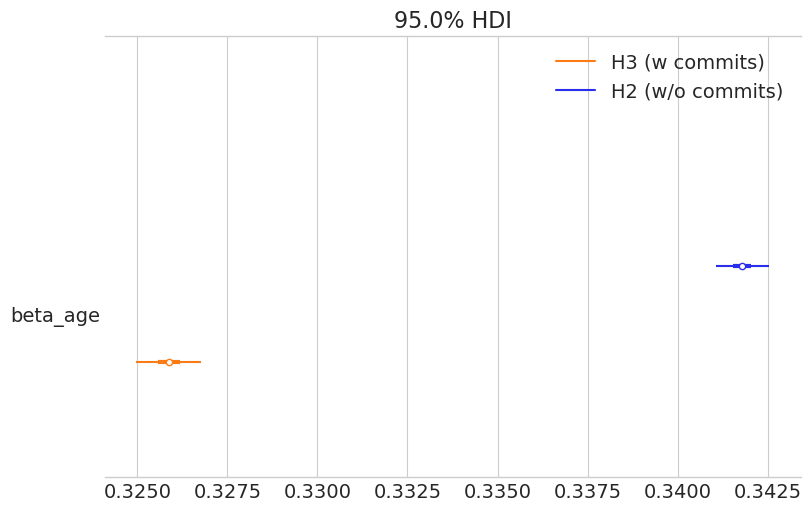

In [90]:
az.plot_forest(
    data=[h2_poisson_trace, h3_poisson_trace],
    model_names = ['H2 (w/o commits)','H3 (w commits)'],
    var_names=['beta_age'],
    hdi_prob=.95,
    combined=True,
    figsize=(8,5));

#### Posterior Predictive Checks for Age
We calculate pareto k values for the data-points, to see influential data-points. We get the same warning as in H2.

In [91]:
pareto_k_h3 = az.loo(h3_poisson_trace, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


For standardized age, we sample $1.127$ points linearly from values between $-1.5$ and $14$, exactly like in H2.

For standardized commits, we sample $1.127$ points of 0. This is simply to remove the effect of `beta_commits`.

This means that we can compare the posterior predictions of the model in H3 with the model in H2 when varying standardized age.

In [92]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq = np.linspace(-1.5, 13, n_points)

with h3_poisson_model:
    pm.set_data({"age_std": x_seq, "commits_std": np.repeat(0, n_points)})
    post_pred_h3 = pm.sample_posterior_predictive(h3_poisson_trace, var_names=["B"])['posterior_predictive']['B']
    
post_pred_h3_mean = post_pred_h3.mean(["chain", "draw"])

Sampling: [B]


Number of points sampled: 1127


We remove the influential data-points from the figure so it is easier to compare the two models.

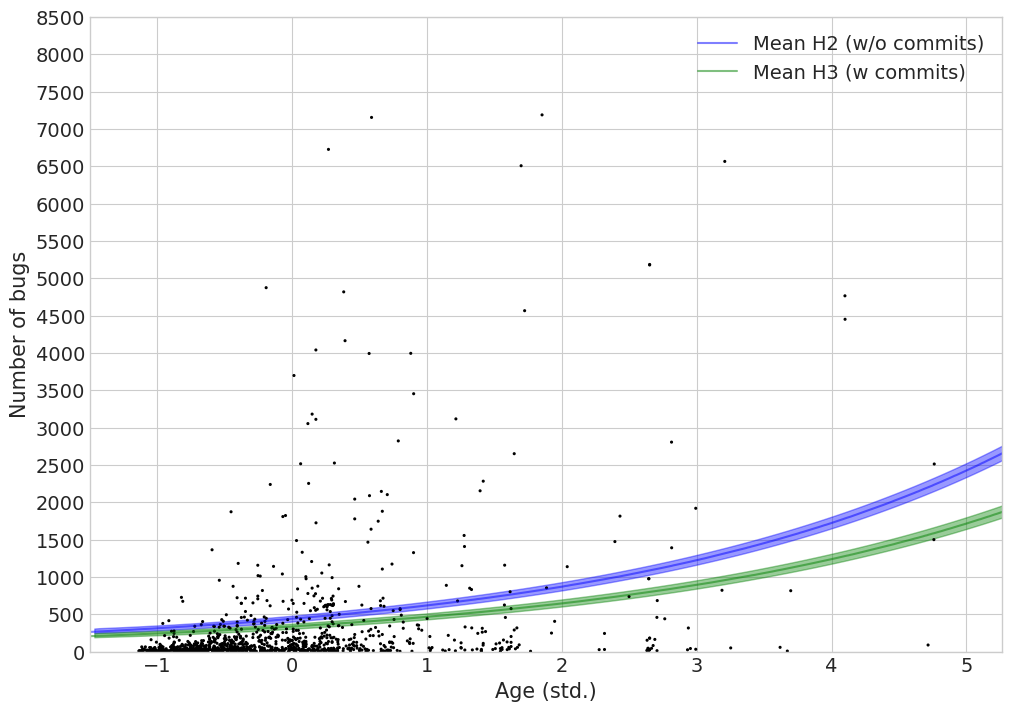

In [93]:
plt.figure(figsize=(10,7))

pareto_k_h3 /= pareto_k_h3.max()
pareto_k_h3_size = 250 * pareto_k_h3

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h3)[-10:][::-1]

pareto_k_size_without_top = np.delete(pareto_k_h3_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h2_mean, color = 'b', alpha=0.5, label='Mean H2 (w/o commits)')

az.plot_hdi(x_seq, post_pred_h3, color = 'g', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h3_mean, color = 'g', alpha=0.5, label='Mean H3 (w commits)')

plt.scatter(df_without_top.age_std, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(-1.5, max(df_without_top.age_std)+0.5)
plt.ylim(0,8500)
plt.xlabel('Age (std.)')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

#### Conclusion H3

The blue line corresponds to the effect of age in `h2_poisson_model` and is the direct effect of age on number of bugs. The green line is the effect of age conditioned on the number of commits. We note that the effect of age conditioned on commits is *smaller* than the direct effect of age. This gives evidence to discard hypothesis 3. Nonetheless, there is still a substantial effect of age after conditioning on commits. We expected to see a smaller effect.

The alpha for model 3 is slightly lower than the alpha for model 2. Subtracting the exponential of their posterior means gives a difference of $exp(6.08) - exp(5.82)=100$.

#### Posterior Predictive Checks for Commits

Next, we make posterior predictions for commits while removing the effect of age.

For standardized commits, we sample $1.127$ points linearly from from values between $-0.15$ and $32$

For standardized age, we sample $1.127$ points of 0. This is simply to remove the effect of `beta_age`.

In [94]:
print(f"Min commits std: {df.commits_std.min():.2f}")
print(f"Max commits std: {df.commits_std.max():.2f}")

Min commits std: -0.14
Max commits std: 31.42


In [96]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq_std = np.linspace(-0.15, 32, n_points)
x_seq = x_seq_std * df['commits'].std() + df['commits'].mean()  # Convert to original commits scale

with h3_poisson_model:
    pm.set_data({"commits_std": x_seq_std, "age_std": np.repeat(0, n_points)})
    post_pred_h3_commits = pm.sample_posterior_predictive(h3_poisson_trace, var_names=["B"])['posterior_predictive']['B']
    
post_pred_h3_commits_mean = post_pred_h3_commits.mean(["chain", "draw"])

Sampling: [B]


Number of points sampled: 1127


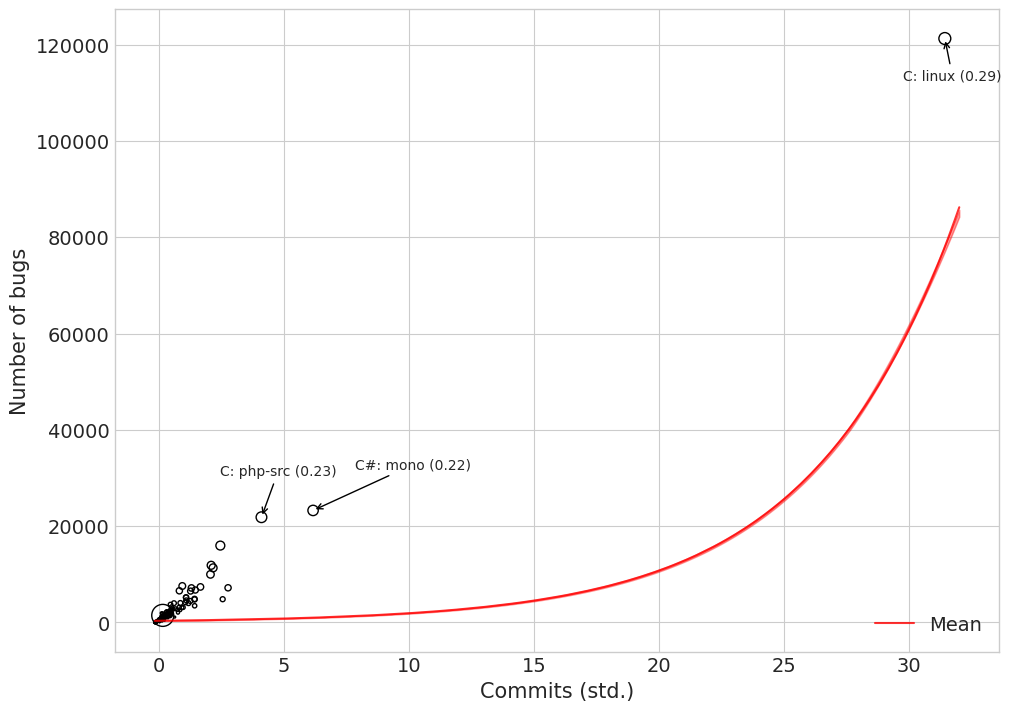

In [103]:
plt.figure(figsize=(10,7))

#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h3 /= pareto_k_h3.max()
pareto_k_h3_size = 250 * pareto_k_h3
pareto_k_h3_size += abs(min(pareto_k_h3_size))+0.001 #fix error with negative size

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h3)[-10:][::-1]
top_data_points = df.iloc[top_indices]


az.plot_hdi(x_seq_std, post_pred_h3_commits, color = 'r', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq_std, post_pred_h3_commits_mean, color = 'r', alpha=0.8, label='Mean')
plt.scatter(df.commits_std, df.bugs, s = pareto_k_h3_size, facecolors='none', edgecolors='k', lw=1)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    dont_annotate = False
    if row['language'] == 7 and row['project'] == 'linux':
        position=(-30,-30)
    elif row['language'] == 5 and row['project'] == 'mono':
        position=(30,30)
    elif row['language'] == 7 and row['project'] == 'php-src':
        position=(-30,30)
    else:
        dont_annotate = True
    if dont_annotate == False:
         plt.annotate(f"{languages[row['language']]}: {row['project']} ({pareto_k_h3[index]:.2f})", xy=(row['commits_std'], row['bugs']), xytext=position,
                     textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.legend(loc = 'lower right');
plt.xlabel('Commits (std.)');
plt.ylabel('Number of bugs');

Like in H2, we see very influential data-points. To better vizualise posterior predictions of commits we "zoom-in" on data-points by removing the influential data-points from the figure. We also use non-standardized commits for the x-axis.

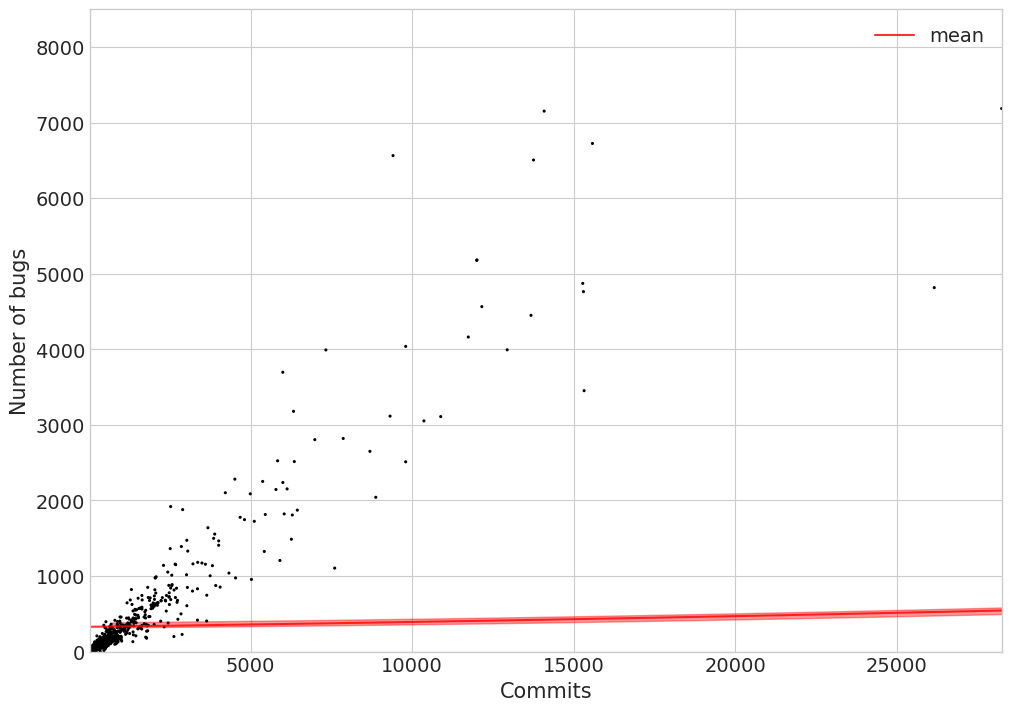

In [106]:
plt.figure(figsize=(10,7))

pareto_k_size_without_top = np.delete(pareto_k_h3_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_h3_commits, color = 'r', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h3_commits_mean, color = 'r', alpha=0.8, label='mean')
plt.scatter(df_without_top.commits, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(min(df_without_top.commits), max(df_without_top.commits)+0.5)
plt.ylim(0,8500)
plt.xlabel('Commits')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 1000));

The effect of commits on number of bugs is clearly not fitted well. We would have expected to see a much larger effect of commits, which would have aligned the mean prediction to the data-points. We dont know why we get such a poor fit. We tried to use different priors for $\beta_C$ but that did not help.

In [113]:
y_at_0 = np.interp(0, x_seq, post_pred_h3_commits_mean)
y_at_1000 = np.interp(1000, x_seq, post_pred_h3_commits_mean)
y_at_10000 = np.interp(10000, x_seq, post_pred_h3_commits_mean)
print(f"Expected number of bugs at 0 commits: {y_at_0:.2f}")
print(f"Expected number of bugs at 1000 commits: {y_at_1000:.2f}")
print(f"Expected number of bugs at 10000 commits: {y_at_10000:.2f}")

Expected number of bugs at 0 commits: 327.91
Expected number of bugs at 1000 commits: 334.02
Expected number of bugs at 10000 commits: 392.20


We see again that the increase in number of bugs in relation to commits is simply too low according to the model . An increase in commits from 0 to 10000 only increases the expected number of bugs from 328 to 392. This is unrealistic and doesnt match with the data. 

In regard to hypothesis 3, since we expect the true effect of commits to be larger than the one we estimated, we also suspect that the effect of age conditioned on commits to be smaller than what we estimated.

This is why we try a different approach in the next section where we model bugs as a real value, i.e. model it with a normal distribution.

Finally, we use information criteria to compare the models for H2 and H3. We note that the waic is much lower in the model for H3 than the model for H2. This means that adding commits as a predictor increases the fit to the data without overfitting. 

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:249: RuntimeWarning: divide by zero encountered in log
  score += np.log(np.dot(exp_ic_i[i], w_full))
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:256: RuntimeWarning: invalid value encountered in scalar divide
  grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

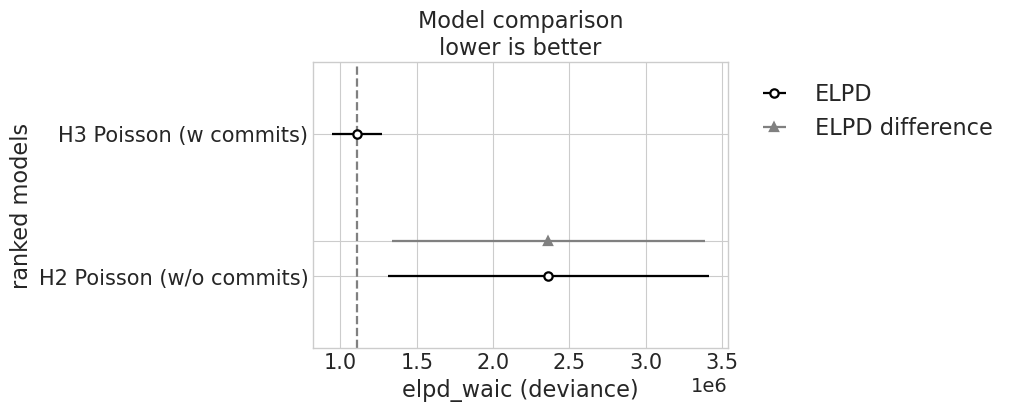

In [129]:
comp = pm.compare({'H2 Poisson (w/o commits)': h2_poisson_trace,
            'H3 Poisson (w commits)': h3_poisson_trace}, 
            ic='waic', scale='deviance')

pm.plot_compare(comp, insample_dev=False, figsize=(10,4))

# Additional Analysis

*In this section we analyse H2 and H3 using different approaches.*

## H2 (Normal Regression)

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

This time we attempt to model Hypothesis 2 in a normal distribution manner by treating number of bugs (B) as a real value and also standardizing it. We believe that this implementation at least gives us a better interpretation.

Contrary to the previous Poisson model for H2, we here include an effect of age on bugs for each programming language. This way we can see whether the effect of age on bugs differs among programming languages.

The model is defined as follows:

$$B_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_{\mathrm{A}[L]} A_i$$
$$\sigma  \sim \text{Not yet determined}$$
$$\alpha  \sim \text{Not yet determined}$$
$$\beta_{\mathrm{A}[L]} \sim \text{Not yet determined}$$


where 
$$L \in \mathcal{L}, where \ \mathcal{L} = \{Python,Java..,C \} \\ |\mathcal{L}|=17 $$


As for the prior for $\sigma$, $\alpha$, and $\beta_{\mathrm{A}[L]}$, we'll set plausible values in the next section.

#### Determine priors 

* Determine prior $\alpha$ and $\sigma$ 

We choose the prior of $\alpha$ to follow a normal distribution. Assuming that a standardized age value takes 0, we expect the corresponding standardized bugs to be 0 as we do not have any information. In other words we expect number of bugs to have a mean value when age also has a mean value. We thereby set the $\alpha$ mean to 0. 

As for the $\alpha$ standard deviation and $\sigma$, we will make adjustments so that the number of bugs follows reasonable values with the $\beta_{\mathrm{A}[L]}$ standard deviation. 

* Determine prior  $\beta_{\mathrm{A}[L]}$

We want the prior for the $\beta_{\mathrm{A}[L]}$ mean to be conservative  i.e. the mean set to 0. 

## H3 (Multilevel Normal Regression)

We design a multilevel model for the normal distribution implementation of hypothesis 3. 

In hypthesis 3, we examine whether the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

In the normal distribution implementation from earlier, we saw that the effect of age drastically reduced when adding commits as a predictor. This effect was consistent for all languages and many effects were close to 0.

In this context we think it is reasonable to introduce to our model that the effect of age on bugs in one language can inform the effect of age in other languages. 

In the multilevel model, we expect to see a shrinkage effect, meaning that the effect of age for each language will be closer to the overall mean of age effect. 

We create a multilevel model for hypothesis 3 with a normal distribution implementation which is similar `h3_normal_model`.

The difference is that the multilevel model is extended with two additional population level parameters (for the population of languages):
* $\bar{\beta}$ - effect of age across languages 
* $\gamma$ -  dispersion in effect of age across languages 

We model the number of standardized bugs $B$ with a Normal distribution.

$$
B_i \sim \mathcal{N}(\mu_i, \sigma)
$$

$$
\mu_i = \alpha + \beta_{A[L]}A_i + \beta_{C[L]}C_i
$$

We re-use the priors for the effect of commits, alpha, and sigma that we determined earlier in `h3_normal_model`.

$$
\beta_{C[L]} \sim N(1, 0.2)
$$

$$
\alpha \sim N(0,0.5)
$$

$$
\sigma \sim \mathrm{Exponential}(1)
$$

The difference from the previous model is, that information learned from a $\beta_{A[L]}$ in one language informs the others through the shared hyper-parameters $\bar{\beta}$ and $\gamma$.

$$
\beta_{A[L]} \sim N(\bar{\beta}, \gamma)
$$

We define the hyperpriors:

$$
\bar{\beta} \sim N(0, 0.2)
$$

$$
\gamma \sim \mathrm{Exponential}(1)
$$   

In [131]:

with pm.Model() as h3_ml_model:
    
    #Hyperpriors
    beta_bar = pm.Normal('beta_bar', 0, 0.2)
    beta_sigma = pm.Exponential('beta_sigma', 1)
    
    alpha = pm.Normal("alpha", 0, 0.5)
    beta_commits = pm.Normal("beta_commits", 1, 0.2, shape=languages.size)
    beta_age = pm.Normal("beta_age", beta_bar, beta_sigma, shape=languages.size)
    
    sigma = pm.Exponential("sigma", 1)

    #We add language_ids and age_std as mutable data so we can change it later in posterior predictions
    language_ids = pm.Data('language_ids', df.language, mutable=True)
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    commits_std = pm.Data("commits_std", df.commits_std, mutable=True)
    
    mu = pm.Deterministic("mu",
                            alpha + beta_age[language_ids] * age_std + beta_commits[language_ids] * commits_std)

    # B = Number of Bugs Standardized
    B = pm.Normal("B", mu = mu, sigma = sigma, observed = df.bugs_std.values)
    
    h3_ml_trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4, target_accept=.99)
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_bar, beta_sigma, alpha, beta_commits, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 155 seconds.


In the diagram of the model parameters we note that `beta_age` now has has two hyper-parameters `beta_bar` and `beta_sigma`. Besides that, the model is the same as `h3_normal_model`.

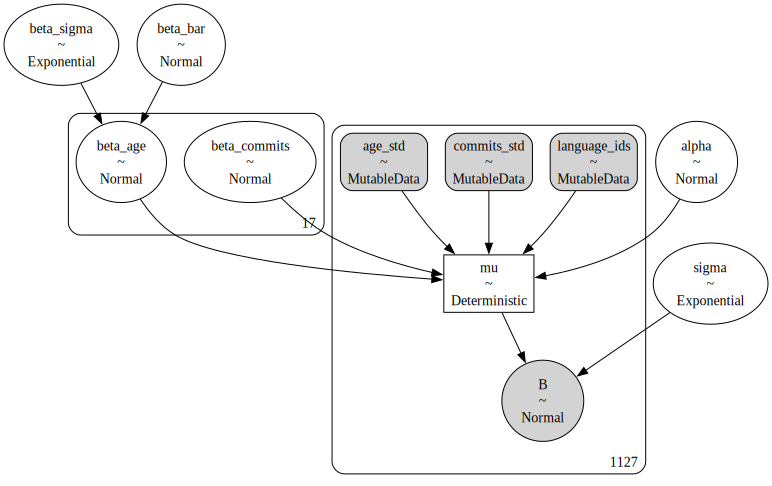

In [132]:
pm.model_to_graphviz(h3_ml_model)

Below is the trace convergence for the parameters .

The effective sample sizes (`ess_bulk`, `ess_tail`) are high which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation.

We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have a good mixing. This is also reflected in the plot below, which shows good mixing of the chains.

Multilevel models often have trouble to converge, but that is not the case for this model.

In [133]:
pm.summary(h3_ml_trace, var_names=['alpha', 'beta_age', 'beta_commits', 'sigma', 'beta_sigma', 'beta_bar'],round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha            -0.01  0.00   -0.01    -0.00        0.0      0.0  11251.13   
beta_age[0]       0.01  0.01   -0.02     0.03        0.0      0.0  10242.90   
beta_age[1]       0.01  0.00   -0.00     0.02        0.0      0.0  12693.74   
beta_age[2]       0.01  0.01   -0.02     0.03        0.0      0.0  11511.81   
beta_age[3]      -0.01  0.01   -0.03     0.01        0.0      0.0   7522.13   
beta_age[4]       0.01  0.01   -0.01     0.03        0.0      0.0  10065.18   
beta_age[5]       0.01  0.01   -0.02     0.03        0.0      0.0   8638.03   
beta_age[6]       0.01  0.01   -0.01     0.03        0.0      0.0  11137.04   
beta_age[7]       0.04  0.01    0.02     0.05        0.0      0.0   9050.42   
beta_age[8]       0.01  0.01   -0.01     0.03        0.0      0.0  12213.97   
beta_age[9]       0.00  0.01   -0.02     0.02        0.0      0.0  10585.86   
beta_age[10]      0.00  0.01   -0.02     0.03        0.0      0.0   6665.74   
beta_age[11]     -0.01  0.01   -0.03     0.01        0.0      0.0   8907.61   
beta_age[12]      0.03  0.01    0.01     0.05        0.0      0.0   7140.02   
beta_age[13]      0.01  0.01   -0.02     0.04        0.0      0.0   8461.87   
beta_age[14]      0.02  0.01    0.00     0.03        0.0      0.0  12606.35   
beta_age[15]      0.02  0.01   -0.01     0.04        0.0      0.0   9319.62   
beta_age[16]      0.02  0.02   -0.01     0.05        0.0      0.0  10321.53   
beta_commits[0]   0.91  0.11    0.70     1.10        0.0      0.0  13164.61   
beta_commits[1]   0.83  0.04    0.75     0.92        0.0      0.0  11801.63   
beta_commits[2]   0.85  0.09    0.69     1.02        0.0      0.0  14023.49   
beta_commits[3]   1.40  0.03    1.35     1.46        0.0      0.0  14514.36   
beta_commits[4]   1.15  0.03    1.10     1.21        0.0      0.0  11475.09   
beta_commits[5]   0.98  0.01    0.95     1.00        0.0      0.0  11641.56   
beta_commits[6]   0.94  0.12    0.71     1.15        0.0      0.0  13078.95   
beta_commits[7]   0.99  0.00    0.99     1.00        0.0      0.0  14857.81   
beta_commits[8]   1.06  0.02    1.02     1.11        0.0      0.0  12024.03   
beta_commits[9]   0.67  0.08    0.53     0.82        0.0      0.0  12952.38   
beta_commits[10]  0.68  0.09    0.52     0.85        0.0      0.0   8289.89   
beta_commits[11]  0.91  0.09    0.75     1.07        0.0      0.0  13678.41   
beta_commits[12]  0.57  0.02    0.52     0.61        0.0      0.0   9428.52   
beta_commits[13]  0.87  0.10    0.67     1.06        0.0      0.0   9635.11   
beta_commits[14]  0.96  0.03    0.90     1.02        0.0      0.0  15528.95   
beta_commits[15]  0.75  0.10    0.55     0.95        0.0      0.0  10766.39   
beta_commits[16]  0.64  0.08    0.50     0.80        0.0      0.0  16738.12   
sigma             0.09  0.00    0.08     0.09        0.0      0.0  15048.36   
beta_sigma        0.02  0.01    0.01     0.03        0.0      0.0   3139.12   
beta_bar          0.01  0.01   -0.00     0.02        0.0      0.0   5611.74   

                  ess_tail  r_hat  
alpha              6123.18    1.0  
beta_age[0]        6139.93    1.0  
beta_age[1]        6342.38    1.0  
beta_age[2]        5962.04    1.0  
beta_age[3]        5420.11    1.0  
beta_age[4]        6260.78    1.0  
beta_age[5]        5659.57    1.0  
beta_age[6]        5510.35    1.0  
beta_age[7]        5582.10    1.0  
beta_age[8]        6333.47    1.0  
beta_age[9]        5988.41    1.0  
beta_age[10]       6629.93    1.0  
beta_age[11]       5361.36    1.0  
beta_age[12]       6069.67    1.0  
beta_age[13]       5961.63    1.0  
beta_age[14]       5685.38    1.0  
beta_age[15]       6016.47    1.0  
beta_age[16]       5768.65    1.0  
beta_commits[0]    6550.35    1.0  
beta_commits[1]    6323.52    1.0  
beta_commits[2]    6144.97    1.0  
beta_commits[3]    5462.58    1.0  
beta_commits[4]    6156.51    1.0  
beta_commits[5]    6650.37    1.0  
beta_commits[6]    5738.90    1.0  


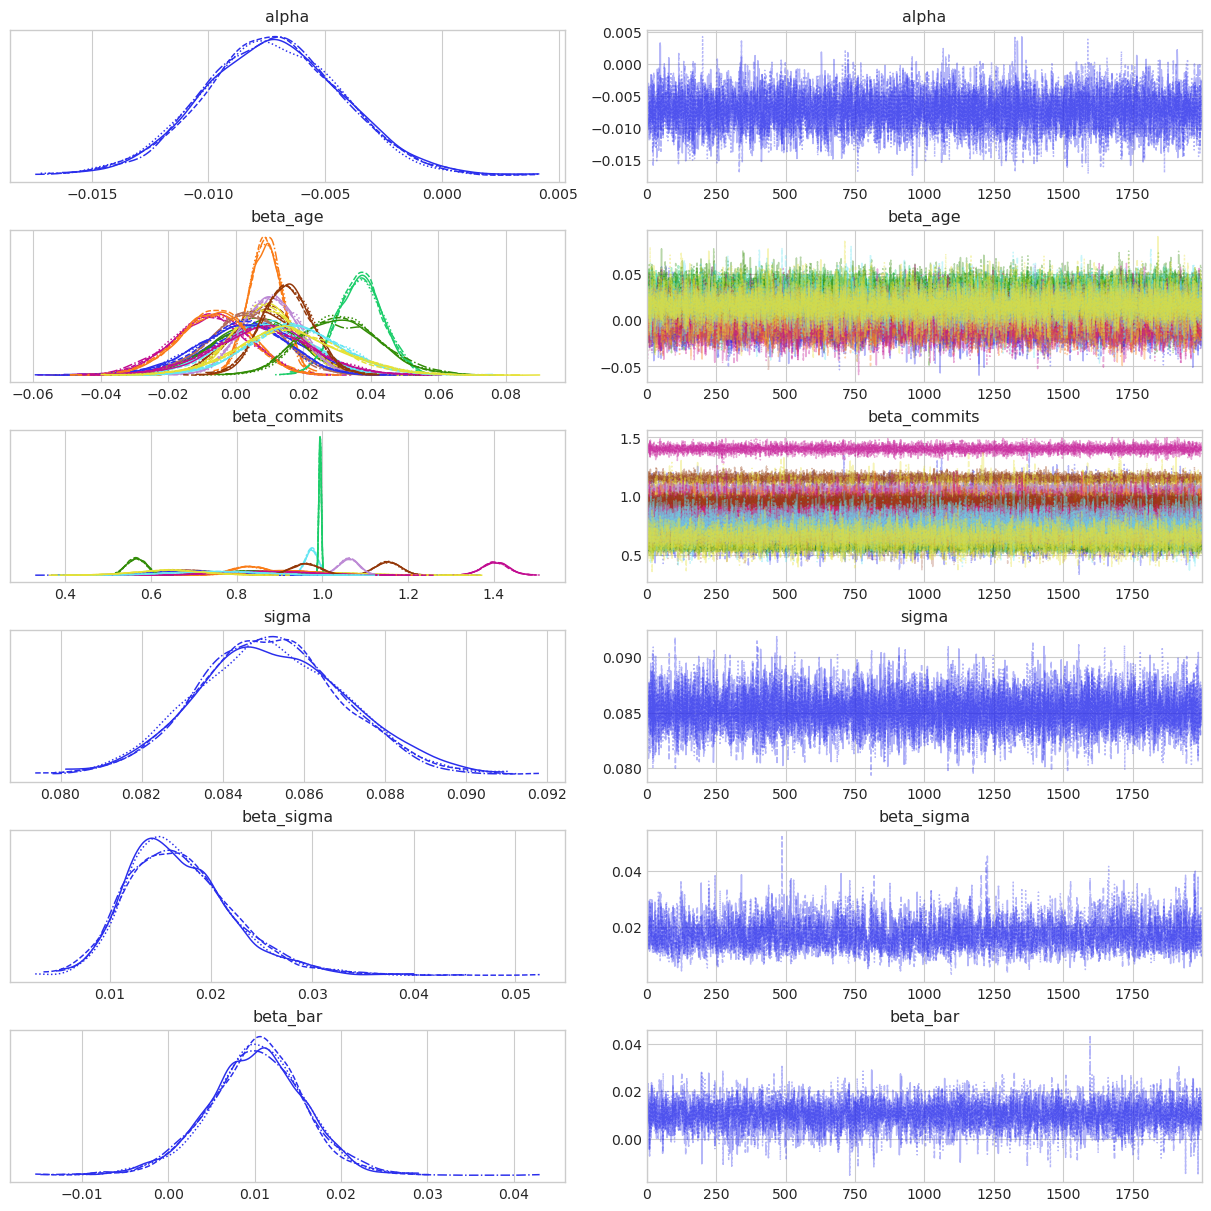

In [135]:
az.plot_trace(h3_ml_trace, var_names=['alpha', 'beta_age', 'beta_commits', 'sigma', 'beta_sigma', 'beta_bar']);

Next we compare the posterior estimates for `beta_age` in `h3_normal_model` (i.e. the no-pooling model) and in the multilevel model `h3_ml_model`.

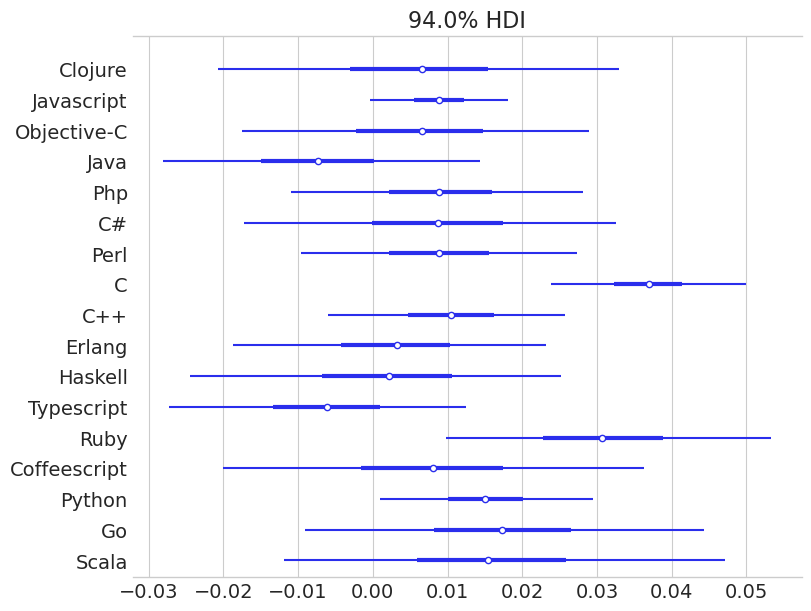

In [136]:
_,ax = plt.subplots(figsize=(8,6))
az.plot_forest(h3_ml_trace, var_names=["beta_age"], combined=True, figsize=(10, 5), ax=ax)
forest_languages = [int(i.get_text()[1:-1]) if len(i.get_text()) < 6 else 0 for i in ax.get_yticklabels()]
ax.set_yticklabels(languages.take(forest_languages)); 

Below is the forest plot for $\bar{\beta}$ and $\gamma$. The effect of of age across all languages $\bar{\beta}$ overlaps with 0 and is also very small.
The dispersion in the effect of age across all languages $\gamma$ is also small meaning that there is some amount of shrinkage effect. 

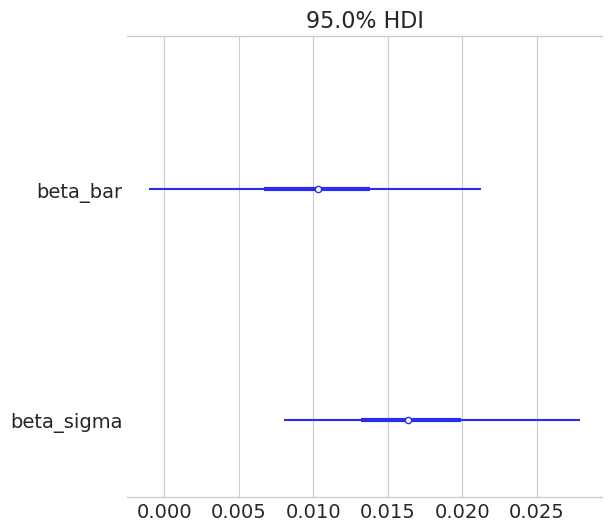

In [139]:
az.plot_forest(h3_ml_trace, var_names = ['beta_bar', 'beta_sigma'], hdi_prob=.95, combined=True);

Lastly we compare the no-pooling model and the multilevel model.

Note the reduced value of `p_waic`??

In [ ]:
comp = pm.compare({'H3 Multilevel': h3_ml_trace,
            'H3 No-Pooling': h3_normal_trace}, 
            ic='waic', scale='deviance')

pm.plot_compare(comp, insample_dev=False, figsize=(10,4))